In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_excel('ikm_2023.xlsx')
data.info()

c:\Program Files\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501765 entries, 0 to 501764
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   NAMA_LAYANAN         501765 non-null  object
 1   NAMA_JENIS_KRITERIA  501765 non-null  object
 2   NRP                  501765 non-null  int64 
 3   NAMA_SKOR_PENILAIAN  501765 non-null  object
 4   BOBOT                501765 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 19.1+ MB


### PREPROCESSING 

In [3]:
num_duplicates = data.duplicated().sum()
print("Jumlah baris duplikat:", num_duplicates)

# Menampilkan baris-baris yang duplikat
duplikat_data = data[data.duplicated(keep=False)]
duplikat_data.to_csv('duplikat_data.csv', index=False)

data = data.drop_duplicates()
num_duplicate = data.duplicated().sum()
print("Jumlah baris setelah menghapus duplikat:", num_duplicate)

Jumlah baris duplikat: 729
Jumlah baris setelah menghapus duplikat: 0


In [4]:
# Mendapatkan nilai unik pada kolom 'NAMA_LAYANAN' dan 'NAMA_JENIS_KRITERIA'
unique_layanan = data['NAMA_LAYANAN'].unique()
unique_kriteria = data['NAMA_JENIS_KRITERIA'].unique()

print("Nilai unik pada kolom 'NAMA_LAYANAN':")
print(unique_layanan)
print("\nNilai unik pada kolom 'NAMA_JENIS_KRITERIA':")
print(unique_kriteria)

Nilai unik pada kolom 'NAMA_LAYANAN':
['ADMINISTRASI AKADEMIK' 'ADMINISTRASI KEMAHASISWAAN'
 'ADMINISTRASI KEPEGAWAIAN' 'ADMINISTRASI KERJASAMA'
 'ADMINISTRASI KEUANGAN' 'ADMINISTRASI UMUM (RUMAH TANGGA)' 'KANTIN'
 'KESEKRETARIATAN' 'LAYANAN DOKTER KAMPUS' 'LAYANAN KEAMANAN'
 'LAYANAN PARKIR' 'LINGKUNGAN KAMPUS' 'MAILING LIST'
 'MANAGEMENT INFORMATION SYSTEM (MIS)' 'PERPUSTAKAAN GEDUNG D3'
 'PERPUSTAKAAN GEDUNG D4' 'PERPUSTAKAAN GEDUNG PASCASARJANA'
 'PORTAL JURUSAN/PRODI' 'PORTAL WEB PENS' 'TOILET']

Nilai unik pada kolom 'NAMA_JENIS_KRITERIA':
['Kecepatan dalam melayani' 'Ketrampilan petugas dalam melayani'
 'Persyaratan pelayanan jelas' 'Petugas disiplin terhadap waktu pelayanan'
 'Petugas yang melayani jelas' 'Prosedur pelayanan mudah (diketahui)'
 'Sikap dan perilaku (perilaku) petugas'
 'Tanggung jawab dan empati petugas'
 'Layanan akses informasi sistem seleksi mahasiswa baru'
 'Layanan karir dan bimbingan kewirausahaan'
 'Layanan kesejahteraan berupa bimbingan konseling, beasis

In [5]:
filtered_data = data[data['NAMA_LAYANAN'] == 'PERPUSTAKAAN GEDUNG PASCASARJANA']
unique_nama_jenis_kriteria = filtered_data['NAMA_JENIS_KRITERIA'].unique()
print("Nilai unik pada kolom 'NAMA_JENIS_KRITERIA':")
print(unique_nama_jenis_kriteria)

unique_count = len(unique_nama_jenis_kriteria)
print(f"\nJumlah nilai unik: {unique_count}")

Nilai unik pada kolom 'NAMA_JENIS_KRITERIA':
['Kecepatan dalam melayani' 'Ketrampilan petugas dalam melayani'
 'Penataan sarana rapi' 'Persyaratan pelayanan jelas'
 'Petugas disiplin terhadap waktu pelayanan' 'Petugas yang melayani jelas'
 'Prosedur pelayanan mudah (diketahui)' 'Ruangan bersih'
 'Sikap dan perilaku (perilaku) petugas'
 'Tanggung jawab dan empati petugas']

Jumlah nilai unik: 10


In [6]:
average_score = data.groupby('NAMA_LAYANAN')['BOBOT'].mean()
sorted_average_score = average_score.sort_values()
print("Rata-rata BOBOT yang diurutkan:")
sorted_average_score.head()

Rata-rata BOBOT yang diurutkan:


NAMA_LAYANAN
TOILET                                 3.085797
PORTAL WEB PENS                        3.087362
KANTIN                                 3.089640
PORTAL JURUSAN/PRODI                   3.091208
MANAGEMENT INFORMATION SYSTEM (MIS)    3.106479
Name: BOBOT, dtype: float64

#### NORMALISASI PRODI DEPARTEMEN

In [7]:
# Fungsi untuk menentukan kategori berdasarkan awalan NRP
def categorize_nrp(nrp):
    nrp_str = str(nrp)
    if str(nrp).startswith('11'):
        return 'S2 Teknik Elektronika'
    elif str(nrp).startswith('12'):
        return 'S2 Teknik Informatika'
    elif str(nrp).startswith('13'):
        return 'D4 LJ Teknik Elektro Industri'
    elif str(nrp).startswith('21'):
        if nrp_str[4:6] == '60':
            return 'D4 Teknik Elektronika'
        elif nrp_str[4:6] == '50':
            return 'D3 Teknik Elektronika'
        elif nrp_str[4:6] == '64':
            return 'D4 LJ Teknik Elektronika'
        elif nrp_str [2:4] == '10':
            return'D4 LJ Teknik Informatika'
        elif nrp_str[2:4] == '03':
            return 'D3 PJJ Teknik Informatika'
    elif str(nrp).startswith('22'):
        if nrp_str[4:6] == '60':
            return 'D4 Teknik Telekomunikasi'
        elif nrp_str[4:6] == '50':
            return 'D3 Teknik Elektro Industri' 
        elif nrp_str [2:4] == '10':
            return 'D4 Teknik Komputer'
        elif nrp_str[4:6]=='61':
            return'D4 PJJ Teknik Telekomunikasi'
        elif nrp_str[4:6] == '64':
            return'D4 LJ Teknik Telekomunikasi'
        elif nrp_str[4:6] == '65':
            return 'D4 LJPJJ Teknik Telekomunikasi'
    elif str(nrp).startswith('23'):
        if nrp_str[4:6] == '60':
            return 'D4 Teknik Elektro Industri'
        elif nrp_str[4:6] == '50':
            return 'D3 Teknik Elektro Industri' 
        elif nrp_str[4:6] == '64':
            return'D4 LJ Teknik Telekomunikasi'
    elif str(nrp).startswith('24'):
        return 'D4 Teknologi Rekayasa Internet' 
    elif str(nrp).startswith('31'):
        if nrp_str[4:6] == '60':
            return 'D4 Teknik Informatika'
        elif nrp_str[4:6] == '50':
            return 'D3 Teknik Informatika'   
        elif nrp_str[2:4] == '10':
            return 'D4 Teknik Mekatronika'  
        elif nrp_str[4:6] == '51':
            return 'D3 PJJ Teknik Informatika' 
        elif nrp_str[4:6] == '52':
            return 'D3 PSDKU Teknik Informatika' 
        elif nrp_str[4:6] == '55':
            return 'D3 LJPJJ Teknik Informatika' 
        elif nrp_str[4:6] == '64':
            return 'D4 LJ Teknik Informatika' 
    elif str(nrp).startswith('32'):
        return 'D4 Teknik Komputer'
    elif str(nrp).startswith('33'):
        return 'D4 Sains Data Terapan'
    elif str(nrp).startswith('41'):
        return 'D4 Teknik Mekatronika'  
    elif str(nrp).startswith('42'):
        return 'D4 Sistem Pembangkit Energi' 
    elif str(nrp).startswith('51'):
        return 'D3 Teknologi Multimedia Broadcasting'   
    elif str(nrp).startswith('52'):
        return 'D4 Teknologi Game'  
    elif str(nrp).startswith('53'):
        return 'D4 Teknologi Rekayasa Multimedia'  
    else:
        return 'Kategori Tidak Diketahui'
data['JURUSAN'] = data['NRP'].apply(categorize_nrp)

nrp_index = data.columns.get_loc('NRP')
cols = data.columns.tolist()
new_order = cols[:nrp_index+1] + ['JURUSAN'] + cols[nrp_index+1:-1]
data = data[new_order]

In [8]:
dte_departments = ['D3 Teknik Elektronika','D4 Teknik Elektronika','D4 LJ Teknik Elektronika','S2 Teknik Elektronika',
                   'D3 Teknik Telekomunikasi','D4 Teknik Telekomunikasi','D4 PJJ Teknik Telekomunikasi','D4 LJ Teknik Telekomunikasi','D4 LJPJJ Teknik Telekomunikasi',
                   'D3 Teknik Elektro Industri','D4 Teknik Elektro Industri','D4 LJ Teknik Elektro Industri','D4 Teknologi Rekayasa Internet']
dtik_departments = ['D3 Teknik Informatika', 'D4 Teknik Informatika', 'D4 LJ Teknik Informatika', 'D3 PSDKU Teknik Informatika', 'D3 LJPJJ Teknik Informatika',
                    'D3 PJJ Teknik Informatika','D3 PJJ Teknik Informatika',
                    'D4 Teknik Komputer', 'D4 Sains Data Terapan', 'S2 Teknik Informatika']
dtme_departments = ['D4 Teknik Mekatronika','D4 Sistem Pembangkit Energi']
dtmk_departments = ['D3 Teknologi Multimedia Broadcasting','D4 Teknologi Game','D4 Teknologi Rekayasa Multimedia']    

def determine_department(jurusan):
    if pd.isna(jurusan) or jurusan.strip() == '':  # Mengecek jika jurusan adalah NaN atau kosong
        return 'Departemen Tidak Diketahui'

    if any(dte in jurusan for dte in dte_departments):
        return 'DTE'
    elif any(dtik in jurusan for dtik in dtik_departments):
        return 'DTIK'
    elif any(dtme in jurusan for dtme in dtme_departments):
        return 'DTME'
    elif any(dtmk in jurusan for dtmk in dtmk_departments):
        return 'DTMK'
    else:
        return 'Departemn tdk diketahui'

data['DEPARTEMEN'] = data['JURUSAN'].apply(determine_department)
jurusan_index = data.columns.get_loc('JURUSAN')

cols = data.columns.tolist()
new_order = cols[:jurusan_index+1] + ['DEPARTEMEN'] + cols[jurusan_index+1:-1]
data = data[new_order]

In [9]:
data['NAMA_SKOR_PENILAIAN'] = data['NAMA_SKOR_PENILAIAN'].replace({
    'tidak': 'Sangat Kurang',     'sulit': 'Sangat Kurang',     'bau': 'Sangat Kurang',    
    'agak': 'Kurang',    'kurang': 'Kurang',     
    'baik': 'Baik',    'rapih': 'Baik',        'mudah': 'Baik',    
    'bersih': 'Baik',       'jelas': 'Baik',     'cepat': 'Baik',    
    'rapi': 'Baik',    'disiplin': 'Baik',     'bagus': 'Baik',     
    'sesuai': 'Baik',    'informatif': 'Baik',    'harum': 'Baik',    
    'up-to-date': 'Baik',     'sangat': 'Sangat Baik',
})

#### NEW DATA

In [10]:
# data1 = data.drop(columns = (['NRP']))
data1 = data.copy()
data1['RESPONDEN'] = 1
data1.to_csv('new_ikm2023.csv', index=False)
data1

,NAMA_LAYANAN,NAMA_JENIS_KRITERIA,NRP,JURUSAN,DEPARTEMEN,NAMA_SKOR_PENILAIAN,BOBOT,RESPONDEN
0,ADMINISTRASI AKADEMIK,Kecepatan dalam melayani,2320600040,D4 Teknik Elektro Industri,DTE,Baik,3,1
1,ADMINISTRASI AKADEMIK,Kecepatan dalam melayani,2222600060,D4 Teknik Telekomunikasi,DTE,Baik,3,1
2,ADMINISTRASI AKADEMIK,Kecepatan dalam melayani,4121600009,D4 Teknik Mekatronika,DTME,Baik,3,1
3,ADMINISTRASI AKADEMIK,Kecepatan dalam melayani,5221600018,D4 Teknologi Game,DTMK,Baik,3,1
4,ADMINISTRASI AKADEMIK,Kecepatan dalam melayani,4220600031,D4 Sistem Pembangkit Energi,DTME,Baik,3,1
...,...,...,...,...,...,...,...,...
501760,TOILET,Persyaratan pelayanan jelas,2322600056,D4 Teknik Elektro Industri,DTE,Sangat Baik,4,1
501761,TOILET,Persyaratan pelayanan jelas,5123500055,D3 Teknologi Multimedia Broadcasting,DTMK,Sangat Baik,4,1
501762,TOILET,Persyaratan pelayanan jelas,2320600003,D4 Teknik Elektro Industri,DTE,Baik,3,1
501763,TOILET,Persyaratan pelayanan jelas,3321600002,D4 Sains Data Terapan,DTIK,Baik,3,1


In [11]:
# Statistik deskriptif per NAMA_LAYANAN dan NAMA_JENIS_KRITERIA
desc_stats = data1.groupby(['NAMA_LAYANAN', 'NAMA_JENIS_KRITERIA'])['BOBOT'].describe()
print("Statistik Deskriptif:")
desc_stats.to_csv('STD2023.csv', index=False)
desc_stats

Statistik Deskriptif:


count  \
NAMA_LAYANAN          NAMA_JENIS_KRITERIA                                 
ADMINISTRASI AKADEMIK Kecepatan dalam melayani                   3238.0   
                      Ketrampilan petugas dalam melayani         3238.0   
                      Persyaratan pelayanan jelas                3238.0   
                      Petugas disiplin terhadap waktu pelayanan  3238.0   
                      Petugas yang melayani jelas                3238.0   
...                                                                 ...   
TOILET                Bau                                        3193.0   
                      Kebersihan closet                          3194.0   
                      Kebersihan ruangan toilet                  3194.0   
                      Kebersihan wastafel                        3194.0   
                      Persyaratan pelayanan jelas                3193.0   

                                                                     mean  \
NAMA_LAYANAN          NAMA_JENIS_KRITERIA                                   
ADMINISTRASI AKADEMIK Kecepatan dalam melayani                   3.166461   
                      Ketrampilan petugas dalam melayani         3.214330   
                      Persyaratan pelayanan jelas                3.189314   
                      Petugas disiplin terhadap waktu pelayanan  3.178505   
                      Petugas yang melayani jelas                3.179123   
...                                                                   ...   
TOILET                Bau                                        2.985280   
                      Kebersihan closet                          3.085473   
                      Kebersihan ruangan toilet                  3.088604   
                      Kebersihan wastafel                        3.110833   
                      Persyaratan pelayanan jelas                3.158785   

                                                                      std  \
NAMA_LAYANAN          NAMA_JENIS_KRITERIA                                   
ADMINISTRASI AKADEMIK Kecepatan dalam melayani                   0.580093   
                      Ketrampilan petugas dalam melayani         0.560588   
                      Persyaratan pelayanan jelas                0.563801   
                      Petugas disiplin terhadap waktu pelayanan  0.586330   
                      Petugas yang melayani jelas                0.581378   
...                                                                   ...   
TOILET                Bau                                        0.704957   
                      Kebersihan closet                          0.616524   
                      Kebersihan ruangan toilet                  0.620640   
                      Kebersihan wastafel                        0.600857   
                      Persyaratan pelayanan jelas                0.568739   

                                                                 min  25%  \
NAMA_LAYANAN          NAMA_JENIS_KRITERIA                                   
ADMINISTRASI AKADEMIK Kecepatan dalam melayani                   1.0  3.0   
                      Ketrampilan petugas dalam melayani         1.0  3.0   
                      Persyaratan pelayanan jelas                1.0  3.0   
                      Petugas disiplin terhadap waktu pelayanan  1.0  3.0   
                      Petugas yang melayani jelas                1.0  3.0   
...                                                              ...  ...   
TOILET                Bau                                        1.0  3.0   
                      Kebersihan closet                          1.0  3.0   
                      Kebersihan ruangan toilet                  1.0  3.0   
                      Kebersihan wastafel                        1.0  3.0   
                      Persyaratan pelayanan jelas                1.0  3.0   

                                                                 50%  75%  max  
NAM

In [12]:
# Menghitung total BOBOT
total_bobot = data1['BOBOT'].sum()
print("Total BOBOT:", total_bobot)  # Output: 9.0 (mengabaikan None)

# Menghitung jumlah nilai BOBOT non-null
count_bobot = data1['BOBOT'].count()
print("Jumlah nilai BOBOT:", count_bobot)  # Output: 4

Total BOBOT: 1602122
Jumlah nilai BOBOT: 501036


In [13]:
total_bobot_layanan = data.groupby(['NAMA_LAYANAN', 'NAMA_JENIS_KRITERIA'])['BOBOT'].sum()
print("Total BOBOT untuk setiap NAMA_JENIS_KRITERIA pada masing-masing NAMA_LAYANAN:\n")
print(total_bobot_layanan)

# total_bobot_layanan.to_csv('bobot_layanan.csv')

Total BOBOT untuk setiap NAMA_JENIS_KRITERIA pada masing-masing NAMA_LAYANAN:

NAMA_LAYANAN           NAMA_JENIS_KRITERIA                      
ADMINISTRASI AKADEMIK  Kecepatan dalam melayani                     10253
                       Ketrampilan petugas dalam melayani           10408
                       Persyaratan pelayanan jelas                  10327
                       Petugas disiplin terhadap waktu pelayanan    10292
                       Petugas yang melayani jelas                  10294
                                                                    ...  
TOILET                 Bau                                           9532
                       Kebersihan closet                             9855
                       Kebersihan ruangan toilet                     9865
                       Kebersihan wastafel                           9936
                       Persyaratan pelayanan jelas                  10086
Name: BOBOT, Length: 158, dtype: int64


In [14]:
# # Menghitung jumlah responden ril
# jumlah_responden_unik = data1['NRP'].nunique()
# print("Jumlah responden unik:", jumlah_responden_unik)

# jumlah_responden_per_departemen = data.groupby('DEPARTEMEN')['NRP'].nunique()
# print("\nJumlah responden unik di setiap departemen:")
# print(jumlah_responden_per_departemen)

# jumlah_responden_per_jurusan = data.groupby('JURUSAN')['NRP'].nunique()
# print("\nJumlah responden unik di setiap jurusan:")
# print(jumlah_responden_per_jurusan)

In [15]:
# jumlah_responden_unik = data1['NRP'].nunique()
# jumlah_responden_per_departemen = data.groupby('DEPARTEMEN')['NRP'].nunique().reset_index()
# jumlah_responden_per_departemen.columns = ['DEPARTEMEN', 'Jumlah_Responden_Unik']
# jumlah_responden_per_jurusan = data.groupby('JURUSAN')['NRP'].nunique().reset_index()
# jumlah_responden_per_jurusan.columns = ['JURUSAN', 'Jumlah_Responden_Unik']
# jumlah_responden_per_departemen['Total_Responden_Unik'] = jumlah_responden_unik
# jumlah_responden_per_jurusan['Total_Responden_Unik'] = jumlah_responden_unik

# gabungan_df = pd.concat([jumlah_responden_per_departemen, jumlah_responden_per_jurusan], axis=0, ignore_index=True)
# gabungan_df

In [16]:
df_tidak_diketahui = data1[data1['DEPARTEMEN'] == 'Departemn tdk diketahui']
# df_tidak_diketahui['NRP_6digit'] = df_tidak_diketahui['NRP'].astype(str).str[:6]
# unique_nrp_6digit_sorted = sorted(df_tidak_diketahui['NRP_6digit'].unique())
# df_unique_nrp_6digit_sorted = pd.DataFrame(unique_nrp_6digit_sorted, columns=['NRP_6digit'])

# df_unique_nrp_6digit_sorted.to_csv('nrp_sorted2023.csv', index=False)

In [17]:
# null_counts = data.isnull().sum()
# print("Jumlah data NaN di setiap kolom: \n", null_counts)

In [18]:
# # Visualisasi distribusi BOBOT untuk setiap NAMA_JENIS_KRITERIA
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='NAMA_JENIS_KRITERIA', y='BOBOT', hue='NAMA_LAYANAN', data=data)
# plt.xticks(rotation=45)
# plt.title('Distribusi BOBOT untuk Setiap NAMA_JENIS_KRITERIA')
# plt.show()

In [19]:
# # Korelasi antara BOBOT dan SKOR_PENILAIAN_NUMERIC
# correlation = data[['BOBOT', 'NAMA_SKOR_PENILAIAN']].corr().iloc[0, 1]
# print(f"Korelasi antara BOBOT dan SKOR_PENILAIAN_NUMERIC: {correlation:.2f}")

#### NORMALISASI JENIS KRITERIA

In [20]:
data1['NAMA_LAYANAN'] = data1['NAMA_LAYANAN'].replace({
    'ADMINISTRASI AKADEMIK': 'AD',
    'ADMINISTRASI KEMAHASISWAAN': 'AKM',
    'ADMINISTRASI KEPEGAWAIAN' : 'AKP',
    'ADMINISTRASI KERJASAMA' : 'AKJ',
    'ADMINISTRASI KEUANGAN' : 'AKU',
    'ADMINISTRASI UMUM (RUMAH TANGGA)' : 'AU',
    'KANTIN' : 'KT',
    'KESEKRETARIATAN' : 'KS',
    'LAYANAN DOKTER KAMPUS' : 'DR',
    'LAYANAN KEAMANAN' : 'LKA',
    'LAYANAN PARKIR' : 'LP',
    'LINGKUNGAN KAMPUS' : 'LK',
    'MAILING LIST' : 'ML',
    'MANAGEMENT INFORMATION SYSTEM (MIS)' : 'MIS',
    'PERPUSTAKAAN GEDUNG D3' : 'P3',
    'PERPUSTAKAAN GEDUNG D4' : 'P4',
    'PERPUSTAKAAN GEDUNG PASCASARJANA' : 'PS',
    'PORTAL JURUSAN/PRODI' : 'PJ',
    'PORTAL WEB PENS' : 'PW',
    'TOILET' : 'TL',
})

In [21]:
# filtered_data = data[data['NAMA_LAYANAN'] == 'AD']

# total_bobot_per_jenis = filtered_data.groupby('NAMA_JENIS_KRITERIA')['BOBOT'].sum()
# print("Total BOBOT untuk setiap NAMA_JENIS_KRITERIA dengan NAMA_LAYANAN 'AD':\n")
# print(total_bobot_per_jenis)

In [22]:
def rename_criteria(row):
    if row['NAMA_LAYANAN'] == 'AD':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'AD1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'AD2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'AD3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'AD4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'AD5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'AD6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'AD7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'AD8'
    elif row['NAMA_LAYANAN'] == 'AKM':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'AKM1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'AKM2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Layanan akses informasi sistem seleksi mahasiswa baru':
            return 'AKM3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Layanan karir dan bimbingan kewirausahaan':
            return 'AKM4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Layanan kesejahteraan berupa bimbingan konseling, beasiswa, dan layanan kesehatan':
            return 'AKM5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Layanan minat dan bakat termasuk kegiatan mahasiswa dan UKM':
            return 'AKM6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Layanan penalaran, dan softskills':
            return 'AKM7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Layanan proses registrasi mahasiswa baru ':
            return 'AKM8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'AKM9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'AKM10'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'AKM11'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'AKM12'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'AKM13'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'AKM14'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'AKM15'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'AKM16'
    elif row['NAMA_LAYANAN'] == 'AKP':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'AKP1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'AKP2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'AKP3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'AKP4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'AKP5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'AKP6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'AKP7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'AKP8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'AKP9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'AKP10'
    elif row['NAMA_LAYANAN'] == 'AKJ':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'AKJ1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'AKJ2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'AKJ3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'AKJ4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'AKJ5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'AKJ6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'AKJ7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'AKJ8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'AKJ9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'AKJ10'
    elif row['NAMA_LAYANAN'] == 'AKU':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'AKU1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'AKU2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'AKU3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'AKU4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'AKU5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'AKU6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'AKU7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'AKU8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'AKU9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'AKU10'
    elif row['NAMA_LAYANAN'] == 'AU':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'AU1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'AU2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'AU3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'AU4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'AU5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'AU6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'AU7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'AU8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'AU9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'AU10'
        
    elif row['NAMA_LAYANAN'] == 'KT':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'KT1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'KT2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'KT3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'KT4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'KT5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'KT6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'KT7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'KT8'
    elif row['NAMA_LAYANAN'] == 'KS':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'KS1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'KS2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'KS3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'KS4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'KS5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'KS6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'KS7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'KS8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'KS9'
    elif row['NAMA_LAYANAN'] == 'DR':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'DR1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'DR2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'DR3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'DR4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'DR5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'DR6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'DR7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'DR8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'DR9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'DR10'
    elif row['NAMA_LAYANAN'] == 'LKA':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'LKA1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'LKA2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'LKA3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'LKA4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'LKA5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'LKA6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'LKA7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'LKA8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'LKA9'
    elif row['NAMA_LAYANAN'] == 'LP':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'LP1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'LP2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'LP3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'LP4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'LP5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'LP6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'LP7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'LP8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'LP9'
    elif row['NAMA_LAYANAN'] == 'LK':
        if row['NAMA_JENIS_KRITERIA'] == 'Lingkungan bersih':
            return 'LK1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan (taman, dll.)  bagus':
            return 'LK2'
    elif row['NAMA_LAYANAN'] == 'ML':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan akses':
            return 'ML1'
    elif row['NAMA_LAYANAN'] == 'MIS':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan akses':
            return 'MIS1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Keragaman fitur/konten':
            return 'MIS2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Konten/berita informatif':
            return 'MIS3'

    elif row['NAMA_LAYANAN'] == 'P3':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'P3_1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'P3_2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'P3_3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'P3_4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'P3_5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'P3_6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'P3_7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'P3_8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'P3_9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'P3_10'
    elif row['NAMA_LAYANAN'] == 'P4':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'P4_1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'P4_2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'P4_3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'P4_4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'P4_5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'P4_6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'P4_7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'P4_8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'P4_9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'P4_10'
    elif row['NAMA_LAYANAN'] == 'PS':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan dalam melayani':
            return 'PS_1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ketrampilan petugas dalam melayani':
            return 'PS_2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Penataan sarana rapi':
            return 'PS_3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'PS_4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas disiplin terhadap waktu pelayanan':
            return 'PS_5'
        elif row['NAMA_JENIS_KRITERIA'] == 'Petugas yang melayani jelas':
            return 'PS_6'
        elif row['NAMA_JENIS_KRITERIA'] == 'Prosedur pelayanan mudah (diketahui)':
            return 'PS_7'
        elif row['NAMA_JENIS_KRITERIA'] == 'Ruangan bersih':
            return 'PS_8'
        elif row['NAMA_JENIS_KRITERIA'] == 'Sikap dan perilaku (perilaku) petugas':
            return 'PS_9'
        elif row['NAMA_JENIS_KRITERIA'] == 'Tanggung jawab dan empati petugas':
            return 'PS_10'
    elif row['NAMA_LAYANAN'] == 'PJ':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan akses':
            return 'PJ1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Keragaman fitur/konten':
            return 'PJ2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Konten/berita informatif':
            return 'PJ3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Konten/berita up-to-date':
            return 'PJ4'
    elif row['NAMA_LAYANAN'] == 'PW':
        if row['NAMA_JENIS_KRITERIA'] == 'Kecepatan akses':
            return 'PW1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Keragaman fitur/konten':
            return 'PW2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Konten/berita informatif':
            return 'PW3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Konten/berita up-to-date':
            return 'PW4'
    elif row['NAMA_LAYANAN'] == 'TL':
        if row['NAMA_JENIS_KRITERIA'] == 'Bau':
            return 'TL1'
        elif row['NAMA_JENIS_KRITERIA'] == 'Kebersihan closet':
            return 'TL2'
        elif row['NAMA_JENIS_KRITERIA'] == 'Kebersihan ruangan toilet':
            return 'TL3'
        elif row['NAMA_JENIS_KRITERIA'] == 'Kebersihan wastafel':
            return 'TL4'
        elif row['NAMA_JENIS_KRITERIA'] == 'Persyaratan pelayanan jelas':
            return 'TL5'

    # Return the original value if no match
    return row['NAMA_JENIS_KRITERIA']

# Apply the renaming function to the DataFrame
data1['NAMA_JENIS_KRITERIA'] = data1.apply(rename_criteria, axis=1)

In [23]:
# data2 = data1.drop(columns = (['NAMA_LAYANAN','JURUSAN','DEPARTEMEN','NAMA_SKOR_PENILAIAN']))
data2 = data1.drop(columns = (['NRP','NAMA_LAYANAN','JURUSAN','DEPARTEMEN','NAMA_SKOR_PENILAIAN','RESPONDEN']))
data2.to_csv('process_ikm2023.csv', index=False)

In [24]:
layanan_ad = data2.iloc[0:3238]
df_pivoted1 = layanan_ad.pivot_table(index=layanan_ad.index, columns='NAMA_JENIS_KRITERIA', values='BOBOT', aggfunc='first')
df_pivoted1.reset_index(drop=True, inplace=True)

layanan_ad.head()

,NAMA_JENIS_KRITERIA,BOBOT
0,AD1,3
1,AD1,3
2,AD1,3
3,AD1,3
4,AD1,3


In [25]:
def process_layanan(data, start_row, end_row, criteria_name):
    subset = data.iloc[start_row:end_row]
    pivoted_df = subset.pivot_table(
        index=subset.index,
        columns='NAMA_JENIS_KRITERIA',
        values='BOBOT',
        aggfunc='first'
    )
    
    pivoted_df.reset_index(drop=True, inplace=True)
    pivoted_df.columns = [criteria_name]
    return pivoted_df
ranges = [
    (0, 3238, 'AD1'),     (3238, 6476, 'AD2'),     (6476, 9714, 'AD3'),    (9714, 12952, 'AD4'),
    (12952, 16190, 'AD5'),    (16190, 19428, 'AD6'),    (19428, 22666, 'AD7'),    (22666, 25904, 'AD8'),
    (25904, 29122, 'AKM1'),    (29122, 32340, 'AKM2'),    (32340, 35558, 'AKM3'),    (35558, 38776, 'AKM4'),
    (38776, 41994, 'AKM5'),    (41994, 45212, 'AKM6'),    (45212, 48430, 'AKM7'),    (48430, 51648, 'AKM8'),
    (51648, 54866, 'AKM9'),    (54867, 58085, 'AKM10'),    (58085, 61303, 'AKM11'),    (61303, 64521, 'AKM12'),
    (64521, 67739, 'AKM13'),    (67739, 70957, 'AKM14'),    (70958, 74176, 'AKM15'),    (74176, 77394, 'AKM16'),
    (77394, 80603, 'AKP1'),    (80603, 83812, 'AKP2'),    (83812, 87021, 'AKP3'),    (87021, 90230, 'AKP4'),    (90230, 93439, 'AKP5'),    
    (93439, 96648, 'AKP6'),    (96648, 99857, 'AKP7'),    (99857, 103066, 'AKP8'),    (103066, 106275, 'AKP9'),    (106275, 109484, 'AKP10'),
    (109484, 112689, 'AKJ1'),    (112690, 115895, 'AKJ2'),    (115896, 119101, 'AKJ3'),    (119101, 122306, 'AKJ4'),    (122307, 125512, 'AKJ5'),
    (125512, 128717, 'AKJ6'),    (128718, 131923, 'AKJ7'),    (131924, 135129, 'AKJ8'),    (135130, 138335, 'AKJ9'),    (138336, 141541, 'AKJ10'),
    (141541, 144753, 'AKU1'),    (144753, 147965, 'AKU2'),    (147965, 151177, 'AKU3'),    (151177, 154389, 'AKU4'),    (154389, 157601, 'AKU5'),
    (157602, 160814, 'AKU6'),    (160814, 164026, 'AKU7'),    (164027, 167239, 'AKU8'),    (167239, 170451, 'AKU9'),    (170452, 173664, 'AKU10'),
    (173664, 176870, 'AU1'),    (176870, 180076, 'AU2'),    (180076, 183282, 'AU3'),    (183282, 186488, 'AU4'),    (186488, 189694, 'AU5'),
    (189694, 192900, 'AU6'),    (192900, 196106, 'AU7'),    (196106, 199312, 'AU8'),    (199312, 202518, 'AU9'),    (202518, 205724, 'AU10'),
    (205724, 208921, 'KT1'),    (208921, 212118, 'KT2'),    (212119, 215316, 'KT3'),    (215317, 218514, 'KT4'),
    (218515, 221712, 'KT5'),    (221712, 224909, 'KT6'),    (224909, 228106, 'KT7'),    (228107, 231304, 'KT8'),
    (231304, 234504, 'KS1'),    (234504, 237704, 'KS2'),    (237704, 240904, 'KS3'),    (240904, 244104, 'KS4'),    (244104, 247304, 'KS5'),
    (247304, 250504, 'KS6'),    (250504, 253704, 'KS7'),    (253704, 256904, 'KS8'),    (256904, 260104, 'KS9'),
    (260104, 263299, 'DR1'),    (263299, 266494, 'DR2'),    (266494, 269689, 'DR3'),    (269689, 272884, 'DR4'),    (272884, 276079, 'DR5'),
    (276079, 279274, 'DR6'),    (279274, 282469, 'DR7'),    (282469, 285664, 'DR8'),    (285664, 288859, 'DR9'),    (288859, 292054, 'DR10'),
    (292054, 295248, 'LKA1'),    (295248, 298442, 'LKA2'),    (298442, 301636, 'LKA3'),    (301636, 304830, 'LKA4'),    (304830, 308024, 'LKA5'),
    (308024, 311218, 'LKA6'),    (311218, 314412, 'LKA7'),    (314412, 317606, 'LKA8'),    (317606, 320800, 'LKA9'),
    (320801, 323996, 'LP1'),    (323996, 327191, 'LP2'),    (327191, 330386, 'LP3'),    (330386, 333581, 'LP4'),    (333581, 336776, 'LP5'),
    (336776, 339971, 'LP6'),    (339971, 343166, 'LP7'),    (343166, 346361, 'LP8'),    (346361, 349556, 'LP9'),
    (349556, 352749, 'LK1'),     (352749, 355942, 'LK2'),    (355942, 359136, 'ML1'),
    (359136, 362326, 'MIS1'),    (362326, 365516, 'MIS2'),    (365516, 368706, 'MIS3'),
    (368707, 371910, 'P3_1'),    (371910, 375113, 'P3_2'),    (375114, 378317, 'P3_3'),    (378318, 381521, 'P3_4'),    (381521, 384724, 'P3_5'),
    (384724, 387927, 'P3_6'),    (387928, 391131, 'P3_7'),    (391132, 394335, 'P3_8'),    (394336, 397539, 'P3_9'),    (397539, 400742,'P3_10'),
    (400743, 403684, 'P4_1'),    (403684, 406625, 'P4_2'),    (406625, 409566, 'P4_3'),    (409566, 412507, 'P4_4'),    (412507, 415448, 'P4_5'),
    (415448, 418389, 'P4_6'),    (418389, 421330, 'P4_7'),    (421330, 424271, 'P4_8'),    (424271, 427212, 'P4_9'),    (427212, 430153, 'P4_10'),
    (430153, 433092, 'PS_1'),    (433092, 436031, 'PS_2'),    (436031, 438970, 'PS_3'),    (438970, 441909, 'PS_4'),    (441909, 444848, 'PS_5'),
    (444848, 447787, 'PS_6'),    (447787, 450726, 'PS_7'),    (450726, 453665, 'PS_8'),    (453665, 456604, 'PS_9'),    (456604, 459543, 'PS_10'),
    (459543, 462733, 'PJ_1'),    (462733, 465923, 'PJ_2'),    (465923, 469113, 'PJ_3'),    (469114, 472304, 'PJ_4'),
    (472305, 475495, 'PW_1'),    (475496, 478686, 'PW_2'),    (478686, 481876, 'PW_3'),    (481877, 485067, 'PW_4'),
    (485068, 488261, 'TL_1'),    (488261, 491454, 'TL_2'),    (491455, 494648, 'TL_3'),    (494649, 497842, 'TL_4'),    (497843, 501036, 'TL_5')
]

processed_dfs = [process_layanan(data2, start, end, name) for start, end, name in ranges]
df_combinedall = pd.concat(processed_dfs, axis=1)

numeric_columns = df_combinedall.select_dtypes(include=['float64', 'int64']).columns
df_combinedall[numeric_columns] = df_combinedall[numeric_columns].fillna(0).astype(int)
df_combinedall.to_csv('combained_ikm2023.csv', index=False)
# df_combinedall.head(2920)
df_combinedall

,AD1,AD2,AD3,AD4,AD5,AD6,AD7,AD8,AKM1,AKM2,...,PJ_4,PW_1,PW_2,PW_3,PW_4,TL_1,TL_2,TL_3,TL_4,TL_5
0,3,3,3,4,3,3,3,3,3,3,...,3,3,4,3,3,3,3,3,3,4
1,3,3,2,3,3,3,3,3,3,3,...,3,2,2,2,4,3,3,3,4,4
2,3,4,4,2,3,3,3,3,3,3,...,4,4,3,2,4,4,4,3,4,3
3,3,4,3,4,4,3,3,3,3,3,...,3,4,3,2,3,3,3,4,3,3
4,3,3,3,3,4,4,4,4,1,3,...,3,3,3,3,3,3,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233,4,4,3,3,2,3,4,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3234,3,3,3,3,3,3,3,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3235,3,3,4,3,3,2,3,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3236,3,3,3,4,3,4,4,3,0,0,...,0,0,0,0,0,0,0,0,0,0


### UJI VALIDITAS, KORELASI

#### PER LAYANAN AD

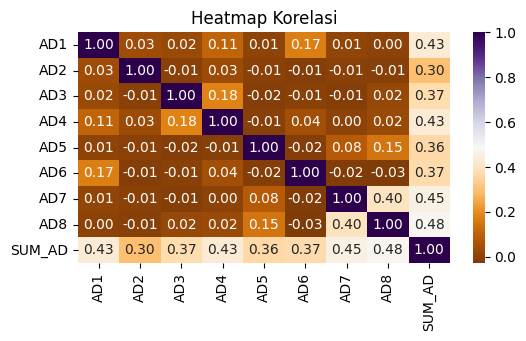

,AD1,AD2,AD3,AD4,AD5,AD6,AD7,AD8,SUM_AD
AD1,1.000000,0.032998,0.024305,0.107225,0.006838,0.170216,0.011198,0.002449,0.429763
AD2,0.032998,1.000000,-0.007463,0.029846,-0.006636,-0.014367,-0.005209,-0.012008,0.299773
AD3,0.024305,-0.007463,1.000000,0.176161,-0.015773,-0.005207,-0.014227,0.015575,0.373873
AD4,0.107225,0.029846,0.176161,1.000000,-0.010471,0.039918,0.002629,0.024295,0.431959
AD5,0.006838,-0.006636,-0.015773,-0.010471,1.000000,-0.016459,0.082673,0.146447,0.362194
AD6,0.170216,-0.014367,-0.005207,0.039918,-0.016459,1.000000,-0.022199,-0.028989,0.368944
AD7,0.011198,-0.005209,-0.014227,0.002629,0.082673,-0.022199,1.000000,0.397750,0.454081
AD8,0.002449,-0.012008,0.015575,0.024295,0.146447,-0.028989,0.397750,1.000000,0.475420
SUM_AD,0.429763,0.299773,0.373873,0.431959,0.362194,0.368944,0.454081,0.475420,1.000000


In [26]:
AD = df_combinedall.loc[0:1000, 'AD1':'AD8'].copy()
AD['SUM_AD'] = AD.sum(axis=1)
AD.insert(AD.columns.get_loc('AD8') + 1, 'SUM_AD', AD.pop('SUM_AD'))
AD

corr_matrix = AD.corr()
plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

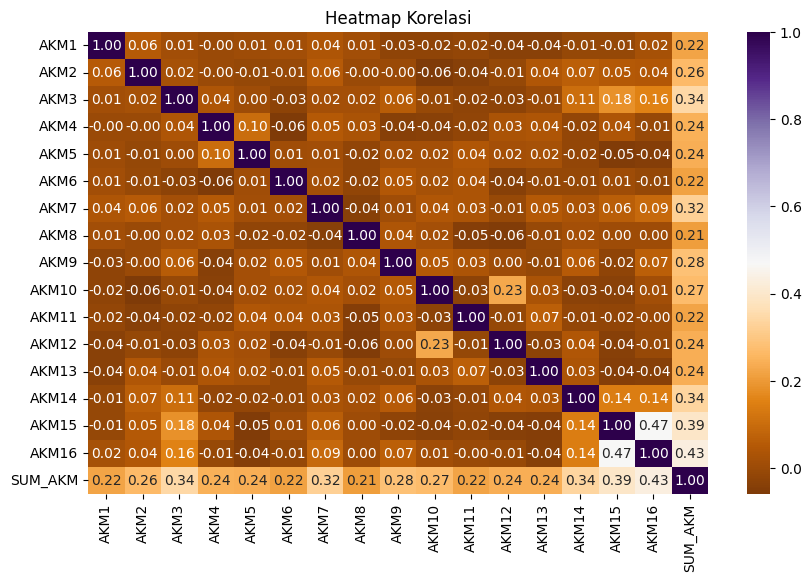

,AKM1,AKM2,AKM3,AKM4,AKM5,AKM6,AKM7,AKM8,AKM9,AKM10,AKM11,AKM12,AKM13,AKM14,AKM15,AKM16,SUM_AKM
AKM1,1.000000,0.055321,0.011033,-0.003527,0.006028,0.013217,0.035712,0.012622,-0.026174,-0.024642,-0.018080,-0.036559,-0.035060,-0.012995,-0.010320,0.021472,0.219032
AKM2,0.055321,1.000000,0.020776,-0.004365,-0.012827,-0.008212,0.056312,-0.002546,-0.001902,-0.056727,-0.040215,-0.013509,0.042296,0.065416,0.050396,0.044644,0.264835
AKM3,0.011033,0.020776,1.000000,0.037497,0.004046,-0.030329,0.018718,0.017924,0.059576,-0.006109,-0.022514,-0.028029,-0.005536,0.105411,0.180936,0.155089,0.343042
AKM4,-0.003527,-0.004365,0.037497,1.000000,0.098991,-0.059513,0.048604,0.027484,-0.040622,-0.038589,-0.018901,0.029640,0.037852,-0.017039,0.036044,-0.008288,0.243580
AKM5,0.006028,-0.012827,0.004046,0.098991,1.000000,0.009921,0.014476,-0.021239,0.016659,0.016952,0.041400,0.017752,0.021751,-0.018029,-0.052310,-0.044115,0.238718
AKM6,0.013217,-0.008212,-0.030329,-0.059513,0.009921,1.000000,0.017360,-0.018136,0.047595,0.019751,0.035212,-0.042409,-0.010270,-0.011879,0.006104,-0.012485,0.217211
AKM7,0.035712,0.056312,0.018718,0.048604,0.014476,0.017360,1.000000,-0.039582,0.006949,0.042112,0.032844,-0.008401,0.050866,0.027898,0.061899,0.090122,0.324387
AKM8,0.012622,-0.002546,0.017924,0.027484,-0.021239,-0.018136,-0.039582,1.000000,0.037891,0.016504,-0.046046,-0.055119,-0.007416,0.017358,0.003010,0.004018,0.206629
AKM9,-0.026174,-0.001902,0.059576,-0.040622,0.016659,0.047595,0.006949,0.037891,1.000000,0.048173,0.031549,0.003790,-0.010952,0.055643,-0.024832,0.065769,0.280063
AKM10,-0.024642,-0.056727,-0.006109,-0.038589,0.016952,0.019751,0.042112,0.016504,0.048173,1.000000,-0.027475,0.227903,0.028353,-0.033358,-0.036760,0.014531,0.270448


In [27]:
AKM = df_combinedall.loc[0:1000, 'AKM1':'AKM16'].copy()
AKM['SUM_AKM'] = AKM.sum(axis=1)
AKM.insert(AKM.columns.get_loc('AKM16') + 1, 'SUM_AKM', AKM.pop('SUM_AKM'))
AKM

corr_matrix = AKM.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

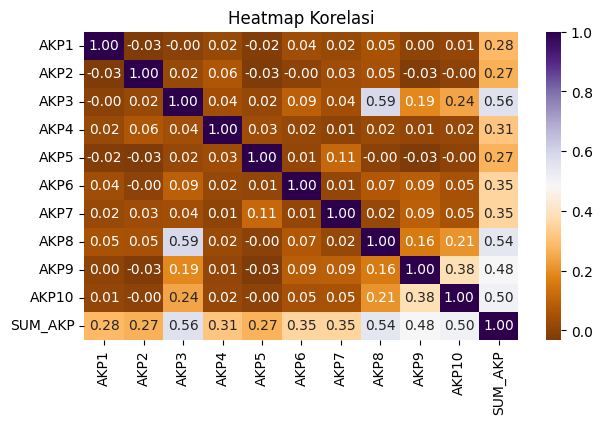

,AKP1,AKP2,AKP3,AKP4,AKP5,AKP6,AKP7,AKP8,AKP9,AKP10,SUM_AKP
AKP1,1.000000,-0.030856,-0.004655,0.021330,-0.019094,0.037506,0.018330,0.052825,0.004675,0.012860,0.279577
AKP2,-0.030856,1.000000,0.019691,0.063640,-0.028238,-0.001412,0.032251,0.048315,-0.025130,-0.000404,0.266178
AKP3,-0.004655,0.019691,1.000000,0.041443,0.015733,0.092034,0.037895,0.587096,0.187111,0.240862,0.561646
AKP4,0.021330,0.063640,0.041443,1.000000,0.032328,0.015636,0.005120,0.022583,0.011313,0.016758,0.313851
AKP5,-0.019094,-0.028238,0.015733,0.032328,1.000000,0.010236,0.110221,-0.004197,-0.028946,-0.000404,0.269184
AKP6,0.037506,-0.001412,0.092034,0.015636,0.010236,1.000000,0.012657,0.069916,0.086992,0.048362,0.353050
AKP7,0.018330,0.032251,0.037895,0.005120,0.110221,0.012657,1.000000,0.015228,0.092471,0.050984,0.352207
AKP8,0.052825,0.048315,0.587096,0.022583,-0.004197,0.069916,0.015228,1.000000,0.156091,0.210229,0.543987
AKP9,0.004675,-0.025130,0.187111,0.011313,-0.028946,0.086992,0.092471,0.156091,1.000000,0.383848,0.484623
AKP10,0.012860,-0.000404,0.240862,0.016758,-0.000404,0.048362,0.050984,0.210229,0.383848,1.000000,0.504842


In [28]:
AKP = df_combinedall.loc[0:1000, 'AKP1':'AKP10'].copy()
AKP['SUM_AKP'] = AKP.sum(axis=1)
AKP.insert(AKP.columns.get_loc('AKP10') + 1, 'SUM_AKP', AKP.pop('SUM_AKP'))
AKP

corr_matrix = AKP.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

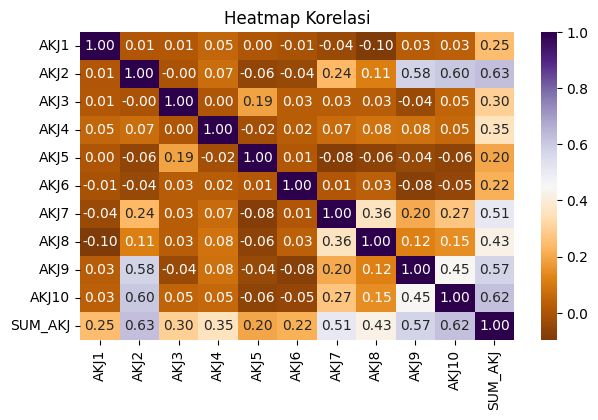

,AKJ1,AKJ2,AKJ3,AKJ4,AKJ5,AKJ6,AKJ7,AKJ8,AKJ9,AKJ10,SUM_AKJ
AKJ1,1.000000,0.007392,0.013632,0.049060,0.004518,-0.009450,-0.040928,-0.096782,0.025577,0.033203,0.246317
AKJ2,0.007392,1.000000,-0.004108,0.069539,-0.056686,-0.042074,0.236854,0.114214,0.576609,0.604849,0.625310
AKJ3,0.013632,-0.004108,1.000000,0.004798,0.188731,0.026998,0.026577,0.026093,-0.037711,0.046721,0.299330
AKJ4,0.049060,0.069539,0.004798,1.000000,-0.019047,0.024619,0.065069,0.084882,0.076362,0.054732,0.353291
AKJ5,0.004518,-0.056686,0.188731,-0.019047,1.000000,0.011409,-0.081267,-0.062585,-0.041832,-0.059345,0.198109
AKJ6,-0.009450,-0.042074,0.026998,0.024619,0.011409,1.000000,0.007124,0.034432,-0.077847,-0.052489,0.216937
AKJ7,-0.040928,0.236854,0.026577,0.065069,-0.081267,0.007124,1.000000,0.359778,0.203585,0.270153,0.508639
AKJ8,-0.096782,0.114214,0.026093,0.084882,-0.062585,0.034432,0.359778,1.000000,0.121149,0.146148,0.425700
AKJ9,0.025577,0.576609,-0.037711,0.076362,-0.041832,-0.077847,0.203585,0.121149,1.000000,0.445102,0.571930
AKJ10,0.033203,0.604849,0.046721,0.054732,-0.059345,-0.052489,0.270153,0.146148,0.445102,1.000000,0.621609


In [29]:
AKJ = df_combinedall.loc[0:1000, 'AKJ1':'AKJ10'].copy()
AKJ['SUM_AKJ'] = AKJ.sum(axis=1)
AKJ.insert(AKJ.columns.get_loc('AKJ10') + 1, 'SUM_AKJ', AKJ.pop('SUM_AKJ'))
AKJ

corr_matrix = AKJ.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

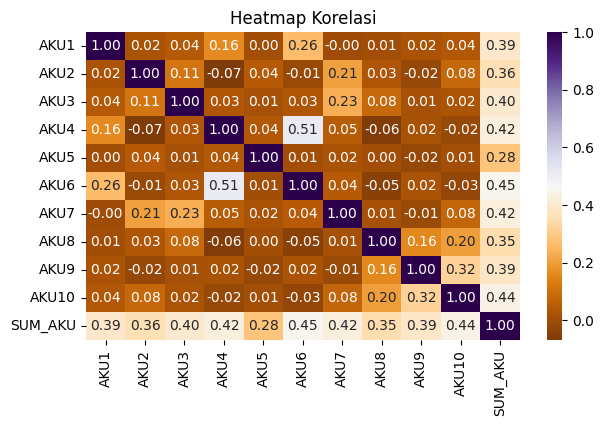

,AKU1,AKU2,AKU3,AKU4,AKU5,AKU6,AKU7,AKU8,AKU9,AKU10,SUM_AKU
AKU1,1.000000,0.022519,0.040711,0.163100,0.003010,0.262435,-0.003901,0.005469,0.022221,0.037895,0.391492
AKU2,0.022519,1.000000,0.114009,-0.069371,0.044930,-0.014901,0.205706,0.029544,-0.021972,0.078923,0.359128
AKU3,0.040711,0.114009,1.000000,0.031863,0.013170,0.029452,0.233194,0.083598,0.013934,0.022786,0.402014
AKU4,0.163100,-0.069371,0.031863,1.000000,0.036543,0.507541,0.051157,-0.061165,0.017620,-0.016366,0.419685
AKU5,0.003010,0.044930,0.013170,0.036543,1.000000,0.005340,0.019029,0.001777,-0.021806,0.007479,0.283042
AKU6,0.262435,-0.014901,0.029452,0.507541,0.005340,1.000000,0.044164,-0.047884,0.018514,-0.026316,0.449919
AKU7,-0.003901,0.205706,0.233194,0.051157,0.019029,0.044164,1.000000,0.012133,-0.013373,0.075310,0.422126
AKU8,0.005469,0.029544,0.083598,-0.061165,0.001777,-0.047884,0.012133,1.000000,0.157991,0.200249,0.352362
AKU9,0.022221,-0.021972,0.013934,0.017620,-0.021806,0.018514,-0.013373,0.157991,1.000000,0.321175,0.389000
AKU10,0.037895,0.078923,0.022786,-0.016366,0.007479,-0.026316,0.075310,0.200249,0.321175,1.000000,0.439167


In [30]:
AKU = df_combinedall.loc[0:1000, 'AKU1':'AKU10'].copy()
AKU['SUM_AKU'] = AKU.sum(axis=1)
AKU.insert(AKU.columns.get_loc('AKU10') + 1, 'SUM_AKU', AKU.pop('SUM_AKU'))
AKU

corr_matrix = AKU.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

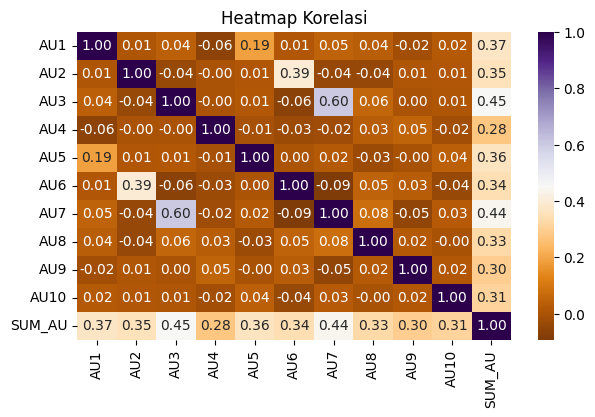

,AU1,AU2,AU3,AU4,AU5,AU6,AU7,AU8,AU9,AU10,SUM_AU
AU1,1.000000,0.010367,0.036537,-0.061373,0.188964,0.012124,0.047465,0.035216,-0.015707,0.022634,0.372705
AU2,0.010367,1.000000,-0.039724,-0.001306,0.011093,0.394565,-0.044491,-0.040841,0.007503,0.013285,0.354009
AU3,0.036537,-0.039724,1.000000,-0.000995,0.014840,-0.062264,0.600420,0.057250,0.000138,0.009428,0.451830
AU4,-0.061373,-0.001306,-0.000995,1.000000,-0.009814,-0.028927,-0.024865,0.027605,0.051286,-0.019122,0.275533
AU5,0.188964,0.011093,0.014840,-0.009814,1.000000,0.002263,0.020070,-0.031175,-0.003065,0.038738,0.364268
AU6,0.012124,0.394565,-0.062264,-0.028927,0.002263,1.000000,-0.091999,0.045370,0.027460,-0.037967,0.341652
AU7,0.047465,-0.044491,0.600420,-0.024865,0.020070,-0.091999,1.000000,0.076825,-0.049556,0.025788,0.438989
AU8,0.035216,-0.040841,0.057250,0.027605,-0.031175,0.045370,0.076825,1.000000,0.022792,-0.003299,0.329163
AU9,-0.015707,0.007503,0.000138,0.051286,-0.003065,0.027460,-0.049556,0.022792,1.000000,0.017445,0.295578
AU10,0.022634,0.013285,0.009428,-0.019122,0.038738,-0.037967,0.025788,-0.003299,0.017445,1.000000,0.310271


In [31]:
AU = df_combinedall.loc[0:1000, 'AU1':'AU10'].copy()
AU['SUM_AU'] = AU.sum(axis=1)
AU.insert(AU.columns.get_loc('AU10') + 1, 'SUM_AU', AU.pop('SUM_AU'))
AU

corr_matrix = AU.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

#### PER LAYANAN KT

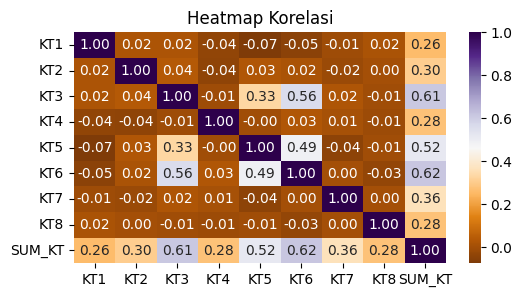

,KT1,KT2,KT3,KT4,KT5,KT6,KT7,KT8,SUM_KT
KT1,1.000000,0.018416,0.020162,-0.035596,-0.074730,-0.048438,-0.010500,0.016528,0.258343
KT2,0.018416,1.000000,0.035520,-0.038575,0.027238,0.015409,-0.018286,0.001670,0.303565
KT3,0.020162,0.035520,1.000000,-0.011424,0.328657,0.561623,0.024058,-0.005986,0.612548
KT4,-0.035596,-0.038575,-0.011424,1.000000,-0.003669,0.028432,0.007793,-0.012937,0.275822
KT5,-0.074730,0.027238,0.328657,-0.003669,1.000000,0.488398,-0.041863,-0.005564,0.519348
KT6,-0.048438,0.015409,0.561623,0.028432,0.488398,1.000000,0.001051,-0.028926,0.617816
KT7,-0.010500,-0.018286,0.024058,0.007793,-0.041863,0.001051,1.000000,0.002157,0.363174
KT8,0.016528,0.001670,-0.005986,-0.012937,-0.005564,-0.028926,0.002157,1.000000,0.277588
SUM_KT,0.258343,0.303565,0.612548,0.275822,0.519348,0.617816,0.363174,0.277588,1.000000


In [32]:
KT = df_combinedall.loc[0:1000, 'KT1':'KT8'].copy()
KT['SUM_KT'] = KT.sum(axis=1)
KT.insert(KT.columns.get_loc('KT8') + 1, 'SUM_KT', KT.pop('SUM_KT'))
KT

corr_matrix = KT.corr()
plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

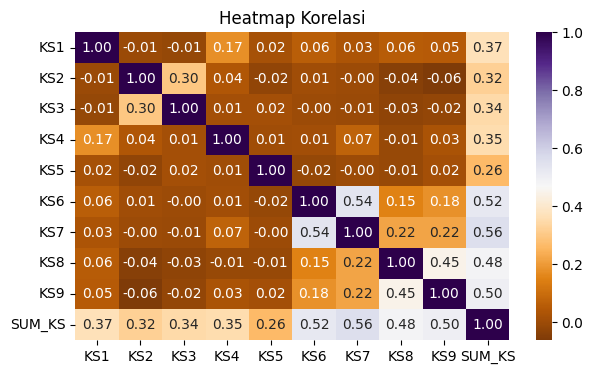

,KS1,KS2,KS3,KS4,KS5,KS6,KS7,KS8,KS9,SUM_KS
KS1,1.000000,-0.008097,-0.013879,0.174736,0.018004,0.059896,0.031994,0.055287,0.050633,0.365877
KS2,-0.008097,1.000000,0.296058,0.037360,-0.023908,0.005953,-0.002831,-0.043806,-0.062336,0.321303
KS3,-0.013879,0.296058,1.000000,0.013665,0.015245,-0.000386,-0.005012,-0.028898,-0.018599,0.344475
KS4,0.174736,0.037360,0.013665,1.000000,0.005845,0.011405,0.073325,-0.009650,0.025947,0.353643
KS5,0.018004,-0.023908,0.015245,0.005845,1.000000,-0.015738,-0.003841,-0.012242,0.015068,0.262832
KS6,0.059896,0.005953,-0.000386,0.011405,-0.015738,1.000000,0.538715,0.150017,0.180169,0.523298
KS7,0.031994,-0.002831,-0.005012,0.073325,-0.003841,0.538715,1.000000,0.215884,0.219382,0.558204
KS8,0.055287,-0.043806,-0.028898,-0.009650,-0.012242,0.150017,0.215884,1.000000,0.447098,0.481811
KS9,0.050633,-0.062336,-0.018599,0.025947,0.015068,0.180169,0.219382,0.447098,1.000000,0.501102
SUM_KS,0.365877,0.321303,0.344475,0.353643,0.262832,0.523298,0.558204,0.481811,0.501102,1.000000


In [33]:
KS = df_combinedall.loc[0:1000, 'KS1':'KS9'].copy()
KS['SUM_KS'] = KS.sum(axis=1)
KS.insert(KS.columns.get_loc('KS9') + 1, 'SUM_KS', KS.pop('SUM_KS'))
KS

corr_matrix = KS.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

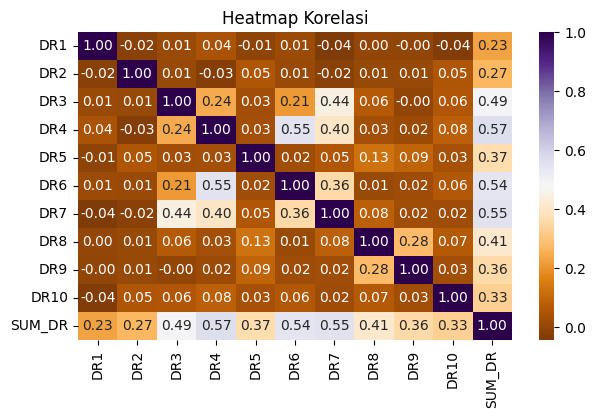

,DR1,DR2,DR3,DR4,DR5,DR6,DR7,DR8,DR9,DR10,SUM_DR
DR1,1.000000,-0.019948,0.011117,0.042182,-0.007351,0.013676,-0.043557,0.000699,-0.003383,-0.036991,0.229052
DR2,-0.019948,1.000000,0.006739,-0.028847,0.052433,0.012508,-0.021412,0.006793,0.006125,0.053246,0.269062
DR3,0.011117,0.006739,1.000000,0.243308,0.026710,0.210441,0.444039,0.064582,-0.004211,0.055743,0.490346
DR4,0.042182,-0.028847,0.243308,1.000000,0.030663,0.547703,0.397616,0.033743,0.015450,0.082431,0.566355
DR5,-0.007351,0.052433,0.026710,0.030663,1.000000,0.024470,0.054953,0.125588,0.094456,0.034213,0.366648
DR6,0.013676,0.012508,0.210441,0.547703,0.024470,1.000000,0.357595,0.012849,0.019286,0.062089,0.539874
DR7,-0.043557,-0.021412,0.444039,0.397616,0.054953,0.357595,1.000000,0.079909,0.023051,0.018176,0.554220
DR8,0.000699,0.006793,0.064582,0.033743,0.125588,0.012849,0.079909,1.000000,0.277012,0.065246,0.409535
DR9,-0.003383,0.006125,-0.004211,0.015450,0.094456,0.019286,0.023051,0.277012,1.000000,0.025858,0.359715
DR10,-0.036991,0.053246,0.055743,0.082431,0.034213,0.062089,0.018176,0.065246,0.025858,1.000000,0.329045


In [34]:
DR = df_combinedall.loc[0:1000, 'DR1':'DR10'].copy()
DR['SUM_DR'] = DR.sum(axis=1)
DR.insert(DR.columns.get_loc('DR10') + 1, 'SUM_DR', DR.pop('SUM_DR'))
DR

corr_matrix = DR.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

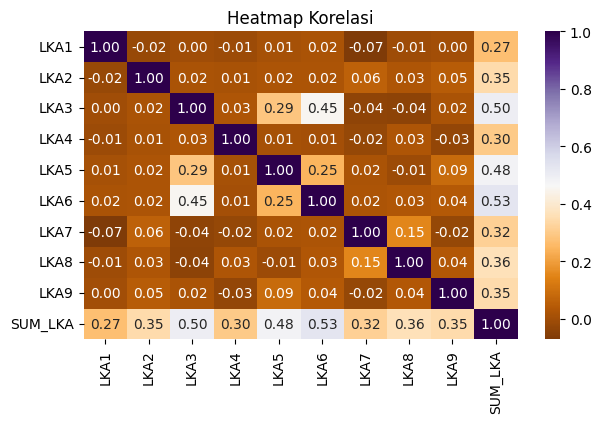

,LKA1,LKA2,LKA3,LKA4,LKA5,LKA6,LKA7,LKA8,LKA9,SUM_LKA
LKA1,1.000000,-0.019046,0.000099,-0.008750,0.008699,0.018342,-0.070937,-0.007535,0.001173,0.268084
LKA2,-0.019046,1.000000,0.017879,0.014220,0.022998,0.021458,0.061438,0.025517,0.049957,0.347147
LKA3,0.000099,0.017879,1.000000,0.028386,0.287411,0.452465,-0.037109,-0.038101,0.020057,0.499606
LKA4,-0.008750,0.014220,0.028386,1.000000,0.010634,0.005188,-0.021338,0.028075,-0.026265,0.297946
LKA5,0.008699,0.022998,0.287411,0.010634,1.000000,0.246192,0.018763,-0.010990,0.085291,0.482049
LKA6,0.018342,0.021458,0.452465,0.005188,0.246192,1.000000,0.024988,0.031890,0.038254,0.530176
LKA7,-0.070937,0.061438,-0.037109,-0.021338,0.018763,0.024988,1.000000,0.153280,-0.022911,0.315644
LKA8,-0.007535,0.025517,-0.038101,0.028075,-0.010990,0.031890,0.153280,1.000000,0.037589,0.362190
LKA9,0.001173,0.049957,0.020057,-0.026265,0.085291,0.038254,-0.022911,0.037589,1.000000,0.345770
SUM_LKA,0.268084,0.347147,0.499606,0.297946,0.482049,0.530176,0.315644,0.362190,0.345770,1.000000


In [35]:
LKA = df_combinedall.loc[0:1000, 'LKA1':'LKA9'].copy()
LKA['SUM_LKA'] = LKA.sum(axis=1)
LKA.insert(LKA.columns.get_loc('LKA9') + 1, 'SUM_LKA', LKA.pop('SUM_LKA'))
LKA

corr_matrix = LKA.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

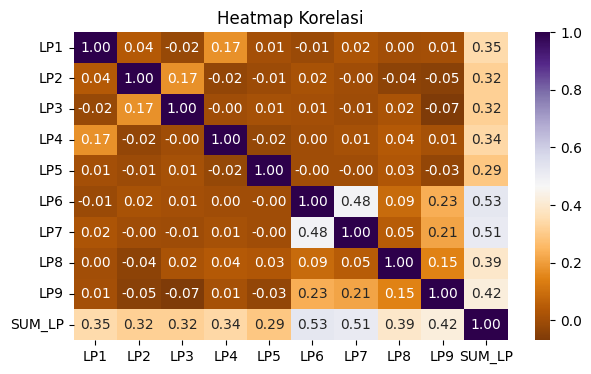

,LP1,LP2,LP3,LP4,LP5,LP6,LP7,LP8,LP9,SUM_LP
LP1,1.000000,0.042628,-0.018797,0.173256,0.006199,-0.013178,0.022068,0.003627,0.006876,0.347446
LP2,0.042628,1.000000,0.174609,-0.023991,-0.008394,0.015599,-0.002612,-0.039032,-0.046268,0.317866
LP3,-0.018797,0.174609,1.000000,-0.001496,0.010439,0.009478,-0.005827,0.019925,-0.069893,0.316556
LP4,0.173256,-0.023991,-0.001496,1.000000,-0.023653,0.000873,0.010862,0.042443,0.010865,0.337897
LP5,0.006199,-0.008394,0.010439,-0.023653,1.000000,-0.000089,-0.002628,0.031059,-0.027836,0.289631
LP6,-0.013178,0.015599,0.009478,0.000873,-0.000089,1.000000,0.482228,0.085401,0.233482,0.527498
LP7,0.022068,-0.002612,-0.005827,0.010862,-0.002628,0.482228,1.000000,0.049202,0.210859,0.513694
LP8,0.003627,-0.039032,0.019925,0.042443,0.031059,0.085401,0.049202,1.000000,0.146852,0.393524
LP9,0.006876,-0.046268,-0.069893,0.010865,-0.027836,0.233482,0.210859,0.146852,1.000000,0.421107
SUM_LP,0.347446,0.317866,0.316556,0.337897,0.289631,0.527498,0.513694,0.393524,0.421107,1.000000


In [36]:
LP = df_combinedall.loc[0:1000, 'LP1':'LP9'].copy()
LP['SUM_LP'] = LP.sum(axis=1)
LP.insert(LP.columns.get_loc('LP9') + 1, 'SUM_LP', LP.pop('SUM_LP'))
LP

corr_matrix = LP.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

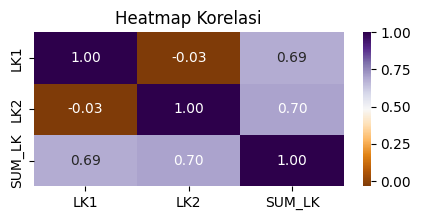

,LK1,LK2,SUM_LK
LK1,1.000000,-0.034662,0.688297
LK2,-0.034662,1.000000,0.701135
SUM_LK,0.688297,0.701135,1.000000


In [37]:
LK = df_combinedall.loc[0:1000, 'LK1':'LK2'].copy()
LK['SUM_LK'] = LK.sum(axis=1)
LK.insert(LK.columns.get_loc('LK2') + 1, 'SUM_LK', LK.pop('SUM_LK'))
LK

corr_matrix = LK.corr()
plt.figure(figsize=(5, 2))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

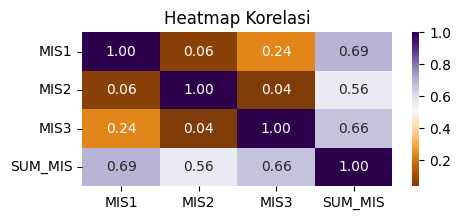

,MIS1,MIS2,MIS3,SUM_MIS
MIS1,1.000000,0.059698,0.236964,0.692627
MIS2,0.059698,1.000000,0.037386,0.558084
MIS3,0.236964,0.037386,1.000000,0.664024
SUM_MIS,0.692627,0.558084,0.664024,1.000000


In [38]:
MIS = df_combinedall.loc[0:1000, 'MIS1':'MIS3'].copy()
MIS['SUM_MIS'] = MIS.sum(axis=1)
MIS.insert(MIS.columns.get_loc('MIS3') + 1, 'SUM_MIS', MIS.pop('SUM_MIS'))
MIS

corr_matrix = MIS.corr()
plt.figure(figsize=(5, 2))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

#### PER LAYANAN P

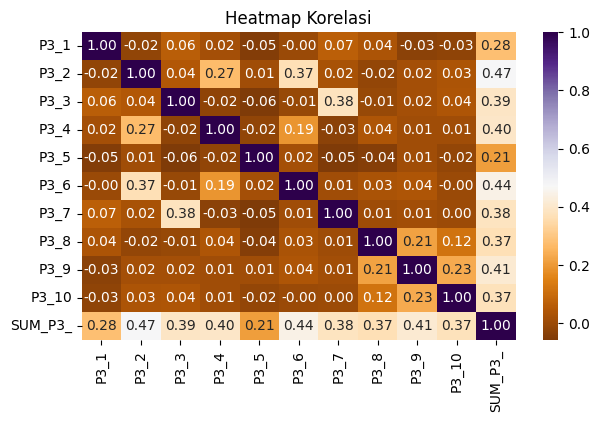

,P3_1,P3_2,P3_3,P3_4,P3_5,P3_6,P3_7,P3_8,P3_9,P3_10,SUM_P3_
P3_1,1.000000,-0.020999,0.062875,0.016982,-0.049201,-0.002371,0.068809,0.035050,-0.032804,-0.025185,0.277732
P3_2,-0.020999,1.000000,0.044758,0.271605,0.010397,0.365805,0.024518,-0.015644,0.017795,0.032746,0.470831
P3_3,0.062875,0.044758,1.000000,-0.023516,-0.059002,-0.005946,0.376062,-0.006634,0.019392,0.038214,0.390921
P3_4,0.016982,0.271605,-0.023516,1.000000,-0.018643,0.189828,-0.033488,0.036773,0.007548,0.007842,0.395096
P3_5,-0.049201,0.010397,-0.059002,-0.018643,1.000000,0.017988,-0.054887,-0.043623,0.010479,-0.016006,0.208938
P3_6,-0.002371,0.365805,-0.005946,0.189828,0.017988,1.000000,0.009946,0.028653,0.039912,-0.003927,0.444603
P3_7,0.068809,0.024518,0.376062,-0.033488,-0.054887,0.009946,1.000000,0.005602,0.013535,0.002600,0.379839
P3_8,0.035050,-0.015644,-0.006634,0.036773,-0.043623,0.028653,0.005602,1.000000,0.214432,0.115041,0.366658
P3_9,-0.032804,0.017795,0.019392,0.007548,0.010479,0.039912,0.013535,0.214432,1.000000,0.233037,0.410129
P3_10,-0.025185,0.032746,0.038214,0.007842,-0.016006,-0.003927,0.002600,0.115041,0.233037,1.000000,0.371595


In [39]:
P3_ = df_combinedall.loc[0:1000, 'P3_1':'P3_10'].copy()
P3_['SUM_P3_'] = P3_.sum(axis=1)
P3_.insert(P3_.columns.get_loc('P3_10') + 1, 'SUM_P3_', P3_.pop('SUM_P3_'))
P3_

corr_matrix = P3_.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

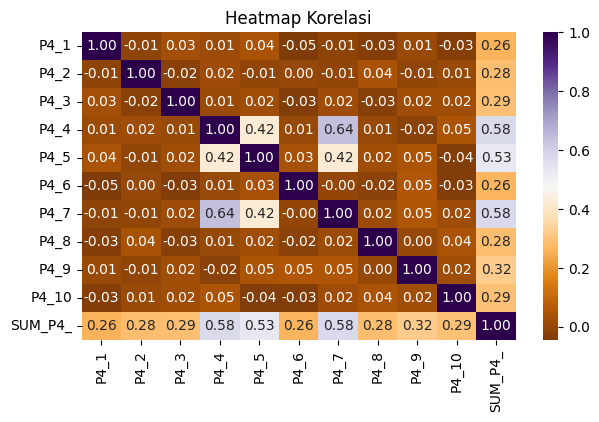

,P4_1,P4_2,P4_3,P4_4,P4_5,P4_6,P4_7,P4_8,P4_9,P4_10,SUM_P4_
P4_1,1.000000,-0.010918,0.028635,0.013966,0.044132,-0.045378,-0.009481,-0.032149,0.008303,-0.032597,0.258261
P4_2,-0.010918,1.000000,-0.024511,0.019460,-0.006836,0.000299,-0.007187,0.039100,-0.006619,0.007926,0.281360
P4_3,0.028635,-0.024511,1.000000,0.010074,0.020242,-0.034628,0.018850,-0.026268,0.021681,0.023988,0.285394
P4_4,0.013966,0.019460,0.010074,1.000000,0.420479,0.006228,0.636963,0.006616,-0.017106,0.045883,0.578623
P4_5,0.044132,-0.006836,0.020242,0.420479,1.000000,0.034826,0.423059,0.020282,0.047993,-0.035837,0.534098
P4_6,-0.045378,0.000299,-0.034628,0.006228,0.034826,1.000000,-0.000958,-0.018133,0.054788,-0.033576,0.261422
P4_7,-0.009481,-0.007187,0.018850,0.636963,0.423059,-0.000958,1.000000,0.015533,0.052309,0.018647,0.581199
P4_8,-0.032149,0.039100,-0.026268,0.006616,0.020282,-0.018133,0.015533,1.000000,0.002933,0.041235,0.284073
P4_9,0.008303,-0.006619,0.021681,-0.017106,0.047993,0.054788,0.052309,0.002933,1.000000,0.022239,0.321031
P4_10,-0.032597,0.007926,0.023988,0.045883,-0.035837,-0.033576,0.018647,0.041235,0.022239,1.000000,0.292500


In [40]:
P4_ = df_combinedall.loc[0:1000, 'P4_1':'P4_10'].copy()
P4_['SUM_P4_'] = P4_.sum(axis=1)
P4_.insert(P4_.columns.get_loc('P4_10') + 1, 'SUM_P4_', P4_.pop('SUM_P4_'))
P4_

corr_matrix = P4_.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

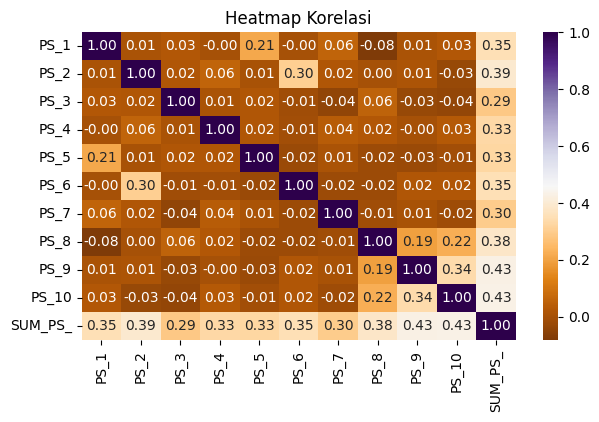

,PS_1,PS_2,PS_3,PS_4,PS_5,PS_6,PS_7,PS_8,PS_9,PS_10,SUM_PS_
PS_1,1.000000,0.008955,0.025216,-0.000903,0.212970,-0.000221,0.061095,-0.082589,0.007471,0.025062,0.348963
PS_2,0.008955,1.000000,0.020337,0.060528,0.005966,0.303042,0.022364,0.001139,0.011154,-0.029578,0.393600
PS_3,0.025216,0.020337,1.000000,0.010308,0.021632,-0.012193,-0.040452,0.055453,-0.031116,-0.038449,0.286705
PS_4,-0.000903,0.060528,0.010308,1.000000,0.020120,-0.007761,0.036023,0.023670,-0.001533,0.028996,0.328236
PS_5,0.212970,0.005966,0.021632,0.020120,1.000000,-0.023465,0.006288,-0.021651,-0.027513,-0.010172,0.327050
PS_6,-0.000221,0.303042,-0.012193,-0.007761,-0.023465,1.000000,-0.021820,-0.019837,0.022106,0.021162,0.352771
PS_7,0.061095,0.022364,-0.040452,0.036023,0.006288,-0.021820,1.000000,-0.012365,0.005512,-0.016750,0.295248
PS_8,-0.082589,0.001139,0.055453,0.023670,-0.021651,-0.019837,-0.012365,1.000000,0.192809,0.224516,0.381169
PS_9,0.007471,0.011154,-0.031116,-0.001533,-0.027513,0.022106,0.005512,0.192809,1.000000,0.336236,0.425117
PS_10,0.025062,-0.029578,-0.038449,0.028996,-0.010172,0.021162,-0.016750,0.224516,0.336236,1.000000,0.430840


In [41]:
PS_ = df_combinedall.loc[0:1000, 'PS_1':'PS_10'].copy()
PS_['SUM_PS_'] = PS_.sum(axis=1)
PS_.insert(PS_.columns.get_loc('PS_10') + 1, 'SUM_PS_', PS_.pop('SUM_PS_'))
PS_

corr_matrix = PS_.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

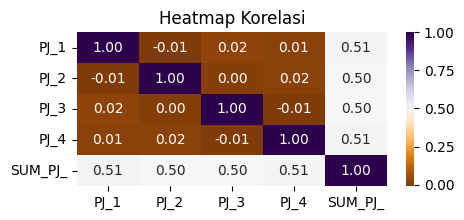

,PJ_1,PJ_2,PJ_3,PJ_4,SUM_PJ_
PJ_1,1.000000,-0.010661,0.021133,0.009300,0.508509
PJ_2,-0.010661,1.000000,0.003391,0.016090,0.497693
PJ_3,0.021133,0.003391,1.000000,-0.010066,0.498020
PJ_4,0.009300,0.016090,-0.010066,1.000000,0.510235
SUM_PJ_,0.508509,0.497693,0.498020,0.510235,1.000000


In [42]:
PJ_ = df_combinedall.loc[0:3189, 'PJ_1':'PJ_4'].copy()
PJ_['SUM_PJ_'] = PJ_.sum(axis=1)
PJ_.insert(PJ_.columns.get_loc('PJ_4') + 1, 'SUM_PJ_', PJ_.pop('SUM_PJ_'))
PJ_

corr_matrix = PJ_.corr()
plt.figure(figsize=(5, 2))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

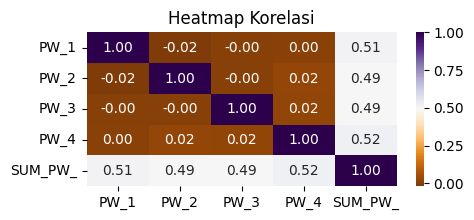

,PW_1,PW_2,PW_3,PW_4,SUM_PW_
PW_1,1.000000,-0.018887,-0.000604,0.002388,0.509740
PW_2,-0.018887,1.000000,-0.002101,0.023184,0.490952
PW_3,-0.000604,-0.002101,1.000000,0.018399,0.492318
PW_4,0.002388,0.023184,0.018399,1.000000,0.517491
SUM_PW_,0.509740,0.490952,0.492318,0.517491,1.000000


In [43]:
PW_ = df_combinedall.loc[0:3189, 'PW_1':'PW_4'].copy()
PW_['SUM_PW_'] = PW_.sum(axis=1)
PW_.insert(PW_.columns.get_loc('PW_4') + 1, 'SUM_PW_', PW_.pop('SUM_PW_'))
PW_

corr_matrix = PW_.corr()
plt.figure(figsize= (5, 2))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

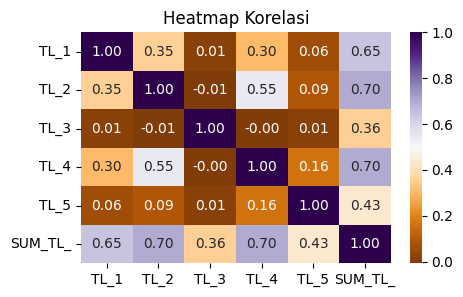

,TL_1,TL_2,TL_3,TL_4,TL_5,SUM_TL_
TL_1,1.000000,0.354601,0.013005,0.301132,0.058184,0.645699
TL_2,0.354601,1.000000,-0.007527,0.545930,0.090808,0.699749
TL_3,0.013005,-0.007527,1.000000,-0.000315,0.012480,0.356270
TL_4,0.301132,0.545930,-0.000315,1.000000,0.159299,0.698972
TL_5,0.058184,0.090808,0.012480,0.159299,1.000000,0.433510
SUM_TL_,0.645699,0.699749,0.356270,0.698972,0.433510,1.000000


In [44]:
TL_ = df_combinedall.loc[0:3192, 'TL_1':'TL_5'].copy()
TL_['SUM_TL_'] = TL_.sum(axis=1)
TL_.insert(TL_.columns.get_loc('TL_5') + 1, 'SUM_TL_', TL_.pop('SUM_TL_'))
TL_

corr_matrix = TL_.corr()
plt.figure(figsize= (5, 3))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Heatmap Korelasi')
plt.show()
corr_matrix

#### SMUA

In [45]:
def jumlahkan_dan_buat_tabel(data, kolom_awal, kolom_akhir, nama_kolom):
    hasil_jumlah = data.iloc[:, kolom_awal:kolom_akhir+1].sum(axis=1)
    tabel_hasil = pd.concat([data.iloc[:, :kolom_akhir+1], hasil_jumlah, data.iloc[:, kolom_akhir+1:]], axis=1)
    tabel_hasil.columns = list(data.columns[:kolom_akhir+1]) + [nama_kolom] + list(data.columns[kolom_akhir+1:])
    return tabel_hasil

operasi1 = jumlahkan_dan_buat_tabel(df_combinedall, 0, 7, 'SUM AD')
operasi2 = jumlahkan_dan_buat_tabel(operasi1, 9, 24, 'SUM AKM')
operasi3 = jumlahkan_dan_buat_tabel(operasi2, 26, 35, 'SUM AKP')
operasi4 = jumlahkan_dan_buat_tabel(operasi3, 37, 46, 'SUM AKJ')
operasi5 = jumlahkan_dan_buat_tabel(operasi4, 48, 57, 'SUM AKU')
operasi6 = jumlahkan_dan_buat_tabel(operasi5, 59, 68, 'SUM AU')
operasi7 = jumlahkan_dan_buat_tabel(operasi6, 70, 77, 'SUM KT')
operasi8 = jumlahkan_dan_buat_tabel(operasi7, 79, 87, 'SUM KS')
operasi9 = jumlahkan_dan_buat_tabel(operasi8, 89, 98, 'SUM DR')
operasi10 = jumlahkan_dan_buat_tabel(operasi9, 100, 108, 'SUM LKA')
operasi11 = jumlahkan_dan_buat_tabel(operasi10, 110, 118, 'SUM LP')
operasi12 = jumlahkan_dan_buat_tabel(operasi11, 120, 121, 'SUM LK')
operasi13 = jumlahkan_dan_buat_tabel(operasi12, 124, 126, 'SUM MIS')
operasi14 = jumlahkan_dan_buat_tabel(operasi13, 128, 137, 'SUM P3')
operasi15 = jumlahkan_dan_buat_tabel(operasi14, 139, 148, 'SUM P4')
operasi16 = jumlahkan_dan_buat_tabel(operasi15, 150, 159, 'SUM PS')
operasi17 = jumlahkan_dan_buat_tabel(operasi16, 161, 164, 'SUM PJ')
operasi18 = jumlahkan_dan_buat_tabel(operasi17, 166, 169, 'SUM PW')
operasi19 = jumlahkan_dan_buat_tabel(operasi18, 171, 175, 'SUM TL')
operasi20 = jumlahkan_dan_buat_tabel(operasi19, 122, 123, 'SUM ML')

operasi20.to_csv('sum_ikm2023.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_20856\414093961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfq['Total_Skor'] = dfq.sum(axis = 1, skipna = True)


,SUM AD,SUM AKM,SUM AKP,SUM AKJ,SUM AKU,SUM AU,SUM KT,SUM KS,SUM DR,SUM LKA,...,SUM LK,SUM ML,SUM MIS,SUM P3,SUM P4,SUM PS,SUM PJ,SUM PW,SUM TL,Total_Skor
SUM AD,1.000000,0.004308,0.015612,0.011086,0.017242,0.037613,0.017804,0.010906,-0.002334,0.011167,...,0.012663,0.010245,0.015999,0.016441,0.008038,0.007551,0.017648,0.039715,0.013302,0.052772
SUM AKM,0.004308,1.000000,0.614620,0.579566,0.644086,0.600192,0.502490,0.545049,0.525585,0.528565,...,0.416142,0.451514,0.407933,0.583201,0.205366,0.204897,0.441739,0.444331,0.423059,0.662443
SUM AKP,0.015612,0.614620,1.000000,0.684058,0.656786,0.705260,0.601866,0.639334,0.601692,0.598864,...,0.471479,0.514937,0.465310,0.678469,0.246065,0.247112,0.518221,0.511496,0.486224,0.736838
SUM AKJ,0.011086,0.579566,0.684058,1.000000,0.635252,0.727957,0.625688,0.671196,0.641266,0.647019,...,0.499835,0.545336,0.497794,0.719550,0.272997,0.273721,0.536265,0.544252,0.511022,0.767445
SUM AKU,0.017242,0.644086,0.656786,0.635252,1.000000,0.665494,0.546634,0.605563,0.572105,0.581939,...,0.432773,0.474615,0.438513,0.631468,0.240578,0.240175,0.484268,0.476248,0.455038,0.706697
SUM AU,0.037613,0.600192,0.705260,0.727957,0.665494,1.000000,0.643031,0.692521,0.653691,0.672270,...,0.526455,0.569419,0.510665,0.733763,0.279025,0.276343,0.556857,0.558705,0.527590,0.786059
SUM KT,0.017804,0.502490,0.601866,0.625688,0.546634,0.643031,1.000000,0.682327,0.690296,0.698364,...,0.552652,0.595152,0.555202,0.663475,0.277061,0.275447,0.592527,0.595249,0.565857,0.759722
SUM KS,0.010906,0.545049,0.639334,0.671196,0.605563,0.692521,0.682327,1.000000,0.700951,0.704749,...,0.552246,0.597408,0.536163,0.727241,0.284944,0.282801,0.592551,0.596562,0.583830,0.788101
SUM DR,-0.002334,0.525585,0.601692,0.641266,0.572105,0.653691,0.690296,0.700951,1.000000,0.751722,...,0.596697,0.639673,0.584162,0.683522,0.317802,0.318474,0.635174,0.630106,0.609264,0.804784
SUM LKA,0.011167,0.528565,0.598864,0.647019,0.581939,0.672270,0.698364,0.704749,0.751722,1.000000,...,0.618934,0.667730,0.607984,0.694579,0.331819,0.332351,0.662824,0.656198,0.627327,0.817615


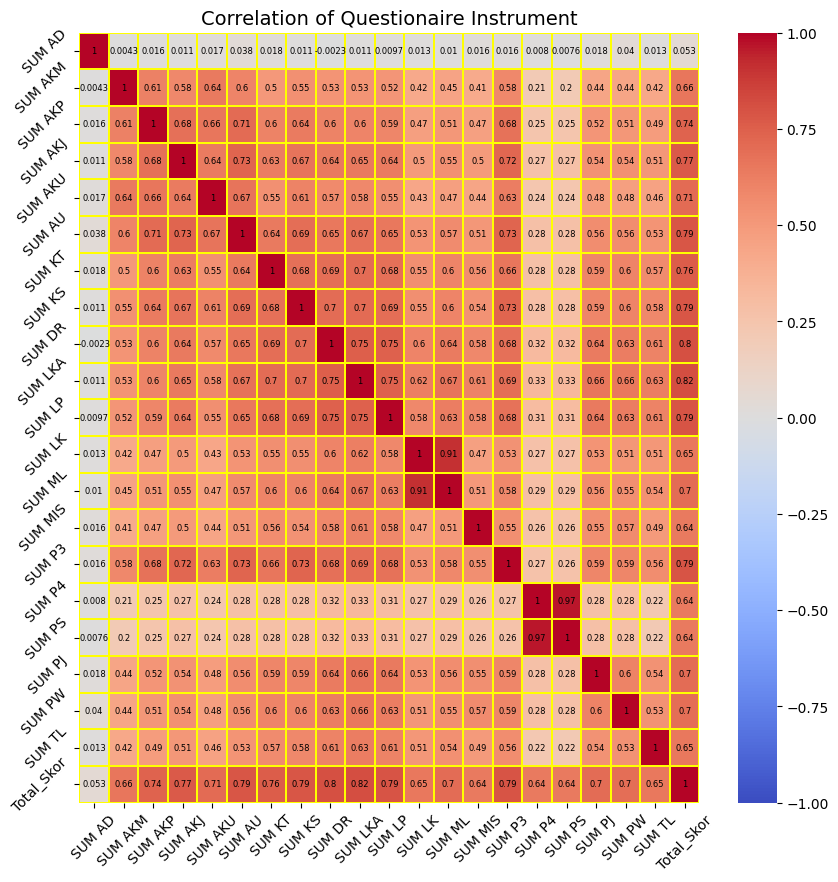

In [46]:
# Memilih kolom-kolom dengan 'SUM P1' hingga 'SUM P5'
dfq = operasi20[['SUM AD', 'SUM AKM', 'SUM AKP', 'SUM AKJ', 'SUM AKU', 
                 'SUM AU', 'SUM KT', 'SUM KS', 'SUM DR', 'SUM LKA', 
                 'SUM LP', 'SUM LK', 'SUM ML', 'SUM MIS', 'SUM P3', 
                 'SUM P4', 'SUM PS','SUM PJ', 'SUM PW', 'SUM TL']]
dfq['Total_Skor'] = dfq.sum(axis = 1, skipna = True)
corr_matrix = dfq.corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,            cmap='coolwarm',           linewidths=0.2,
            linecolor='YELLOW',           cbar=True,           vmin=-1,
            vmax=1,            annot=True,      annot_kws={'size':6,'color':'black'})
plt.tick_params(labelsize=10, rotation=45)
plt.title('Correlation of Questionaire Instrument', size=14)
plt.savefig("corr_quest.png")

corr_matrix

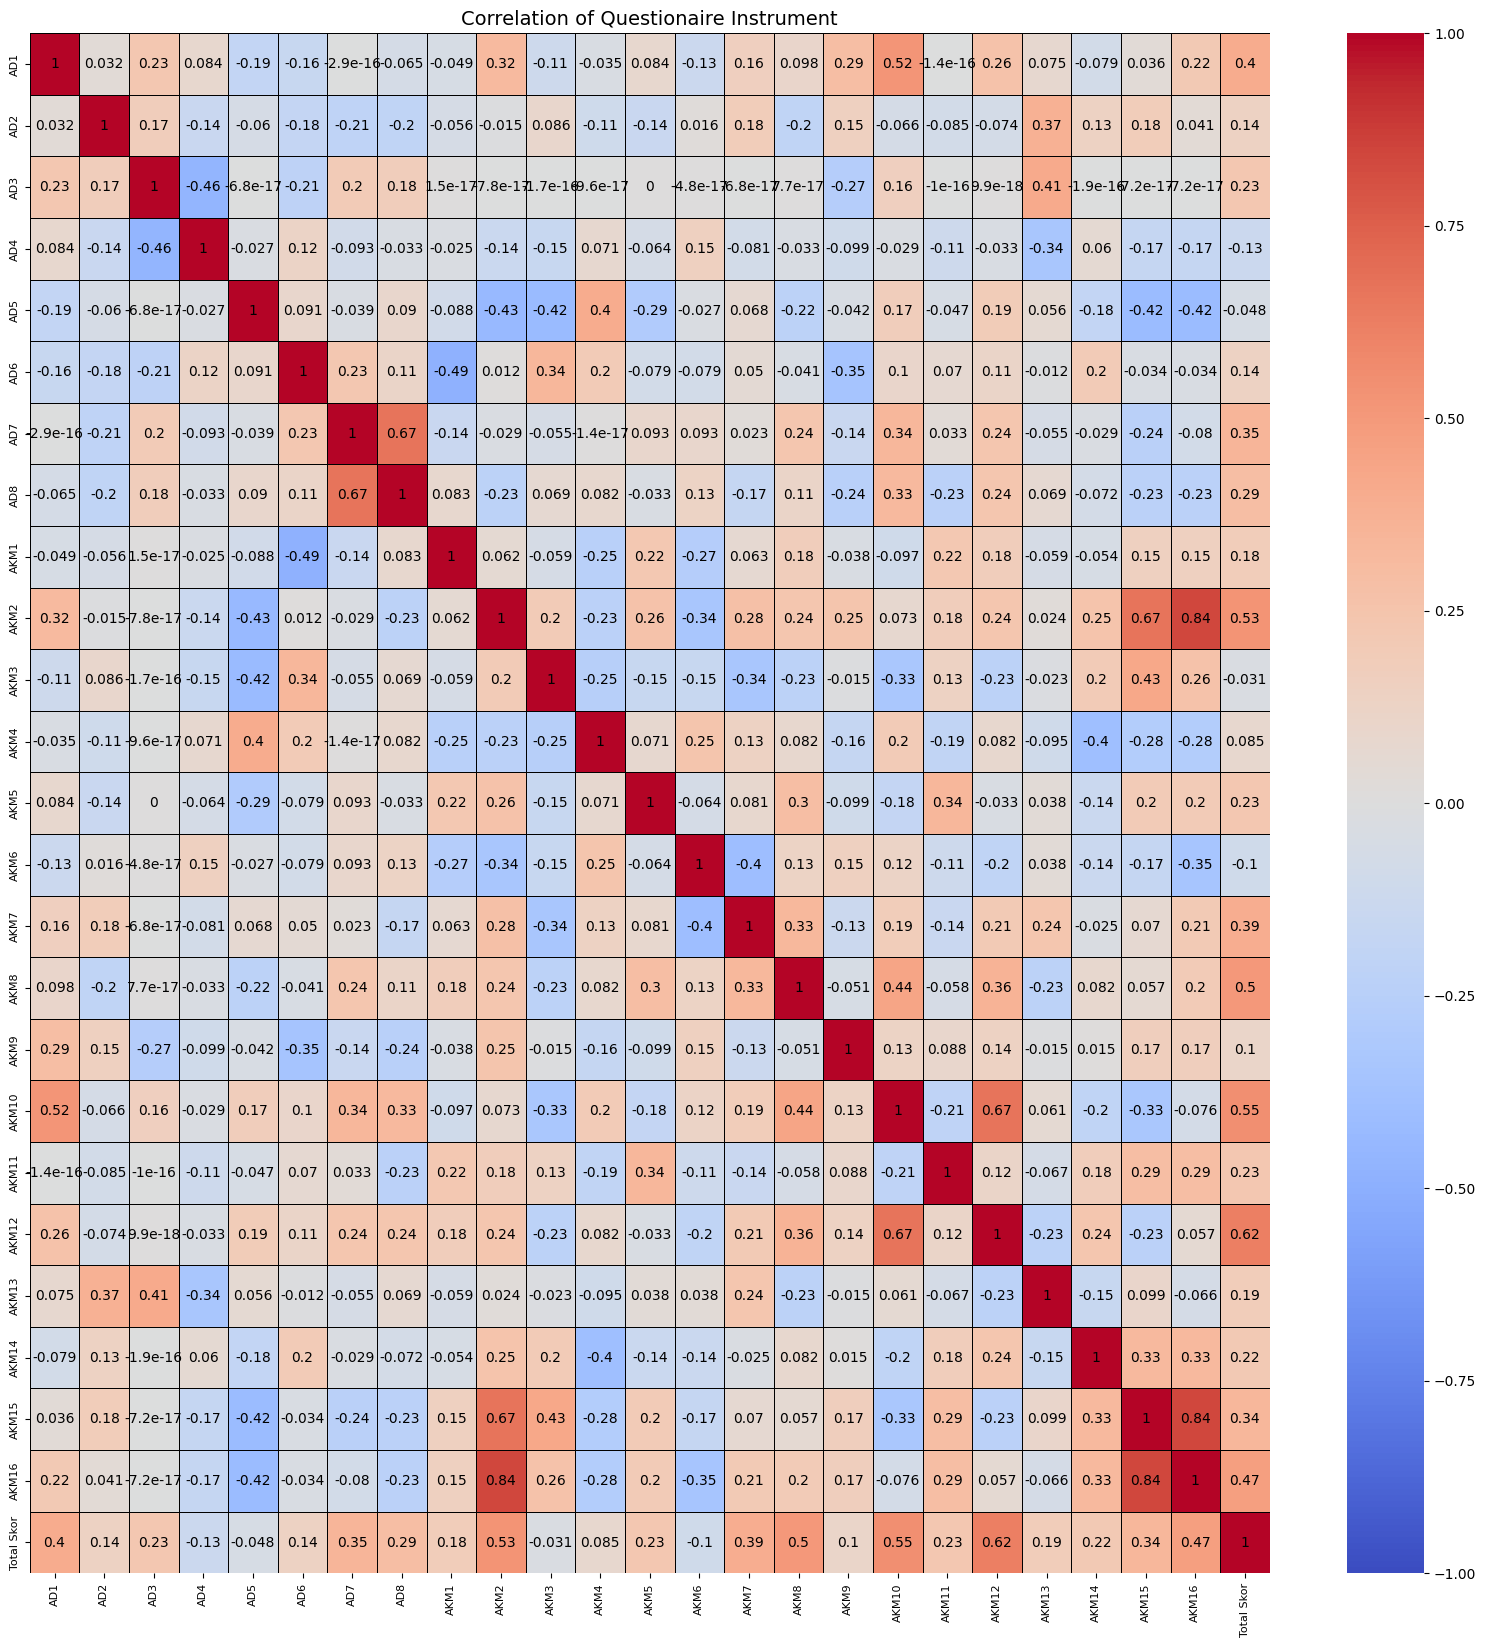

In [47]:
# dfr = df_combinedall.iloc[0:29]
dfr = df_combinedall.loc[0:29,'AD1':'AKM16']
dfr['Total Skor'] = dfr.sum(axis = 1, skipna = True)

corr_matrix = dfr.corr()
fig = plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,             cmap='coolwarm',            linewidths=0.5,
            linecolor='black',           cbar=True,            vmin=-1,
            vmax=1,            annot=True,            annot_kws={'size':10,'color':'black'})
plt.tick_params(labelsize=8, rotation=90)
plt.title('Correlation of Questionaire Instrument', size=14)
plt.savefig("corr_quest1.png")

In [48]:
dfr.corr(method = 'pearson')

,AD1,AD2,AD3,AD4,AD5,AD6,AD7,AD8,AKM1,AKM2,...,AKM8,AKM9,AKM10,AKM11,AKM12,AKM13,AKM14,AKM15,AKM16,Total Skor
AD1,1.000000e+00,0.031686,2.282177e-01,0.084215,-1.854996e-01,-0.156174,-2.920652e-16,-0.065094,-4.902903e-02,3.152442e-01,...,9.764168e-02,0.294174,0.523114,-1.427457e-16,2.603778e-01,0.075378,-7.881104e-02,3.636965e-02,2.182179e-01,0.400373
AD2,3.168621e-02,1.000000,1.735525e-01,-0.144097,-6.045717e-02,-0.178148,-2.096655e-01,-0.198009,-5.592760e-02,-1.498334e-02,...,-1.980093e-01,0.149140,-0.066302,-8.502303e-02,-7.425348e-02,0.372596,1.348501e-01,1.797770e-01,4.148699e-02,0.138603
AD3,2.282177e-01,0.173553,1.000000e+00,-0.461266,-6.848647e-17,-0.213850,2.013468e-01,0.178269,1.490714e-17,-7.787737e-17,...,7.669315e-17,-0.268543,0.159179,-1.019805e-16,9.895890e-18,0.412861,-1.857076e-16,-7.187756e-17,-7.187756e-17,0.229112
AD4,8.421519e-02,-0.144097,-4.612656e-01,1.000000,-2.678038e-02,0.118370,-9.287436e-02,-0.032892,-2.477394e-02,-1.393788e-01,...,-3.289165e-02,-0.099096,-0.029369,-1.129865e-01,-3.289165e-02,-0.342790,5.973378e-02,-1.653954e-01,-1.653954e-01,-0.129837
AD5,-1.854996e-01,-0.060457,-6.848647e-17,-0.026780,1.000000e+00,0.091049,-3.896630e-02,0.089700,-8.835014e-02,-4.344056e-01,...,-2.208000e-01,-0.041577,0.172511,-4.740455e-02,1.932000e-01,0.055930,-1.837870e-01,-4.163589e-01,-4.163589e-01,-0.048140
AD6,-1.561738e-01,-0.178148,-2.138497e-01,0.118370,9.104912e-02,1.000000,2.296425e-01,0.111827,-4.900511e-01,1.230822e-02,...,-4.066418e-02,-0.352224,0.099852,6.984303e-02,1.118265e-01,-0.011772,1.969315e-01,-3.407991e-02,-3.407991e-02,0.138121
AD7,-2.920652e-16,-0.209666,2.013468e-01,-0.092874,-3.896630e-02,0.229642,1.000000e+00,0.670018,-1.441875e-01,-2.897151e-02,...,2.392920e-01,-0.144187,0.341868,3.287980e-02,2.392920e-01,-0.055419,-2.897151e-02,-2.406555e-01,-8.021849e-02,0.347081
AD8,-6.509446e-02,-0.198009,1.782685e-01,-0.032892,8.969998e-02,0.111827,6.700175e-01,1.000000,8.297947e-02,-2.257271e-01,...,1.101695e-01,-0.242555,0.325384,-2.328890e-01,2.372881e-01,0.068694,-7.182226e-02,-2.272764e-01,-2.272764e-01,0.290962
AKM1,-4.902903e-02,-0.055928,1.490714e-17,-0.024774,-8.835014e-02,-0.490051,-1.441875e-01,0.082979,1.000000e+00,6.182447e-02,...,1.787250e-01,-0.038462,-0.096892,2.192645e-01,1.787250e-01,-0.059131,-5.409641e-02,1.497862e-01,1.497862e-01,0.183994
AKM2,3.152442e-01,-0.014983,-7.787737e-17,-0.139379,-4.344056e-01,0.012308,-2.897151e-02,-0.225727,6.182447e-02,1.000000e+00,...,2.359874e-01,0.247298,0.073293,1.762268e-01,2.359874e-01,0.023762,2.546584e-01,6.707212e-01,8.427010e-01,0.526525


### UJI RELIABILITAS

In [49]:
dfc = df_combinedall.copy()

In [50]:
dft = dfc.iloc[0:29]
dft['Total Skor'] = dft.sum(axis = 1, skipna = True)
dft.head()

C:\Users\User\AppData\Local\Temp\ipykernel_20856\3377768277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Total Skor'] = dft.sum(axis = 1, skipna = True)


,AD1,AD2,AD3,AD4,AD5,AD6,AD7,AD8,AKM1,AKM2,...,PW_1,PW_2,PW_3,PW_4,TL_1,TL_2,TL_3,TL_4,TL_5,Total Skor
0,3,3,3,4,3,3,3,3,3,3,...,3,4,3,3,3,3,3,3,4,497
1,3,3,2,3,3,3,3,3,3,3,...,2,2,2,4,3,3,3,4,4,494
2,3,4,4,2,3,3,3,3,3,3,...,4,3,2,4,4,4,3,4,3,495
3,3,4,3,4,4,3,3,3,3,3,...,4,3,2,3,3,3,4,3,3,494
4,3,3,3,3,4,4,4,4,1,3,...,3,3,3,3,3,3,3,3,4,493


In [51]:
df_combi = dfc.iloc[0:2920]
df_combi

,AD1,AD2,AD3,AD4,AD5,AD6,AD7,AD8,AKM1,AKM2,...,PJ_4,PW_1,PW_2,PW_3,PW_4,TL_1,TL_2,TL_3,TL_4,TL_5
0,3,3,3,4,3,3,3,3,3,3,...,3,3,4,3,3,3,3,3,3,4
1,3,3,2,3,3,3,3,3,3,3,...,3,2,2,2,4,3,3,3,4,4
2,3,4,4,2,3,3,3,3,3,3,...,4,4,3,2,4,4,4,3,4,3
3,3,4,3,4,4,3,3,3,3,3,...,3,4,3,2,3,3,3,4,3,3
4,3,3,3,3,4,4,4,4,1,3,...,3,3,3,3,3,3,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,4,3,3,3,3,1,3,3,3,3,...,3,2,3,3,2,4,4,3,3,3
2916,2,4,3,3,3,3,4,4,4,3,...,2,4,3,3,3,3,3,3,3,3
2917,4,3,3,3,3,4,4,4,3,4,...,3,4,3,3,4,3,3,3,3,4
2918,4,4,3,3,3,3,3,3,3,3,...,3,2,4,3,3,3,3,3,4,4


In [52]:
def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = np.array([])
    
    for i, col in enumerate(df_corr.columns):
        sum = df_corr[col][i+1:].values 
        rs = np.append(sum, rs)
    mean_r= np.mean(rs)
    
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [53]:
cronbach_alpha(dfc)

0.976616638523525

In [54]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(dfc)
chi_square_value, p_value

(238838.42950448682, 0.0)

In [55]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(dfc)
kmo_model

c:\Program Files\Python312\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.9844661052574082

In [56]:
import pingouin as pg
pg.cronbach_alpha(data=dft)

(0.5424703128780093, array([0.272, 0.75 ]))

In [57]:
pg.cronbach_alpha(data=dfc, ci=.99)

(0.9763104324511629, array([0.975, 0.978]))

### Analisis faktor

In [58]:
fa = FactorAnalyzer()
fa.fit(dfc)
eigen_values, vectors = fa.get_eigenvalues()
eigen_values

array([36.03663735, 13.02632064,  3.29597274,  1.95083674,  1.60409368,
        1.54305091,  1.5139688 ,  1.43001712,  1.41622013,  1.35341674,
        1.30735708,  1.29891233,  1.28242894,  1.24012152,  1.2081358 ,
        1.20293872,  1.17102338,  1.13666458,  1.12423028,  1.11447527,
        1.09308409,  1.07627533,  1.06780175,  1.05364609,  1.04182451,
        1.02257327,  1.00777967,  0.99856696,  0.98747655,  0.97954351,
        0.97254708,  0.96216405,  0.95508737,  0.94364985,  0.92555381,
        0.9161428 ,  0.89655703,  0.89203091,  0.88492829,  0.87245342,
        0.86362724,  0.86085836,  0.85669311,  0.85401604,  0.83998188,
        0.83847815,  0.82655992,  0.82326164,  0.8165284 ,  0.811526  ,
        0.80370255,  0.80254322,  0.79553717,  0.79290403,  0.78331857,
        0.78127056,  0.77449287,  0.76775915,  0.76273752,  0.75807831,
        0.75600025,  0.75287441,  0.74569564,  0.74307523,  0.73756381,
        0.73051969,  0.72356287,  0.72250622,  0.71713207,  0.71

In [59]:
n_eigen = np.sum(eigen_values > 2)
n_eigen

3

#### scree plot

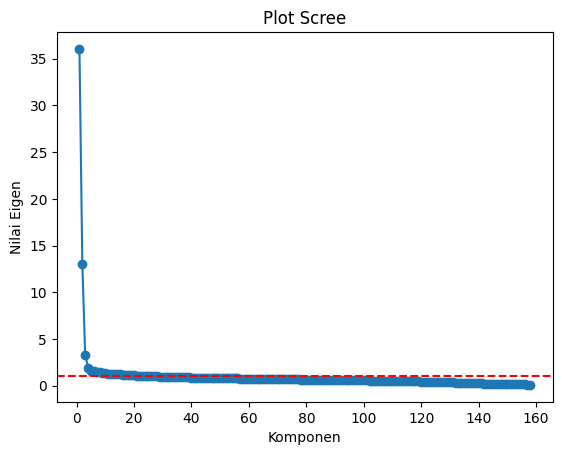

In [60]:
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o')
plt.xlabel('Komponen')
plt.ylabel('Nilai Eigen')
plt.title('Plot Scree')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

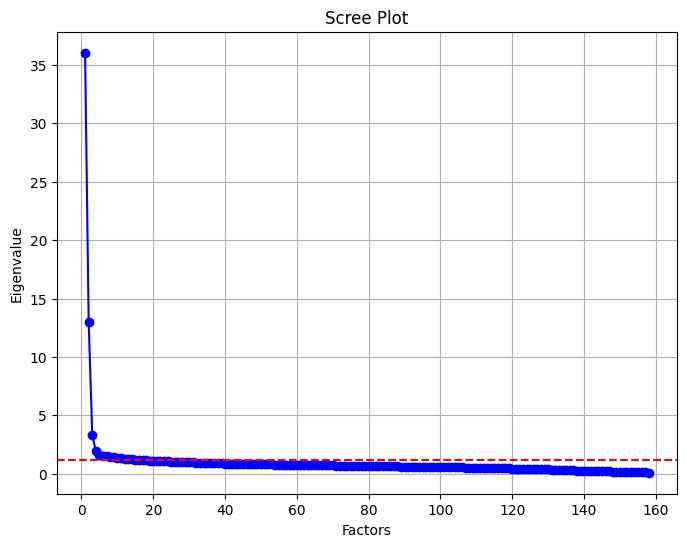

In [61]:
factors = np.arange(1, len(eigen_values) + 1)
plt.figure(figsize=(8, 6))
plt.plot(factors, eigen_values, 'bo-')  
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid(True)  

plt.axhline(y=1.19, color='red', linestyle='--')
plt.gca().set_facecolor('white')
plt.show()

In [62]:
# # Create scree plot using matplotlib
# plt.scatter(range(1,df_combi.shape[1]+1),eigen_values)
# plt.plot(range(1,df_combi.shape[1]+1),eigen_values)
# plt.title('Scree Plot')
# plt.xlabel('Factors')
# plt.ylabel('Eigenvalue')
# plt.grid()
# plt.show()

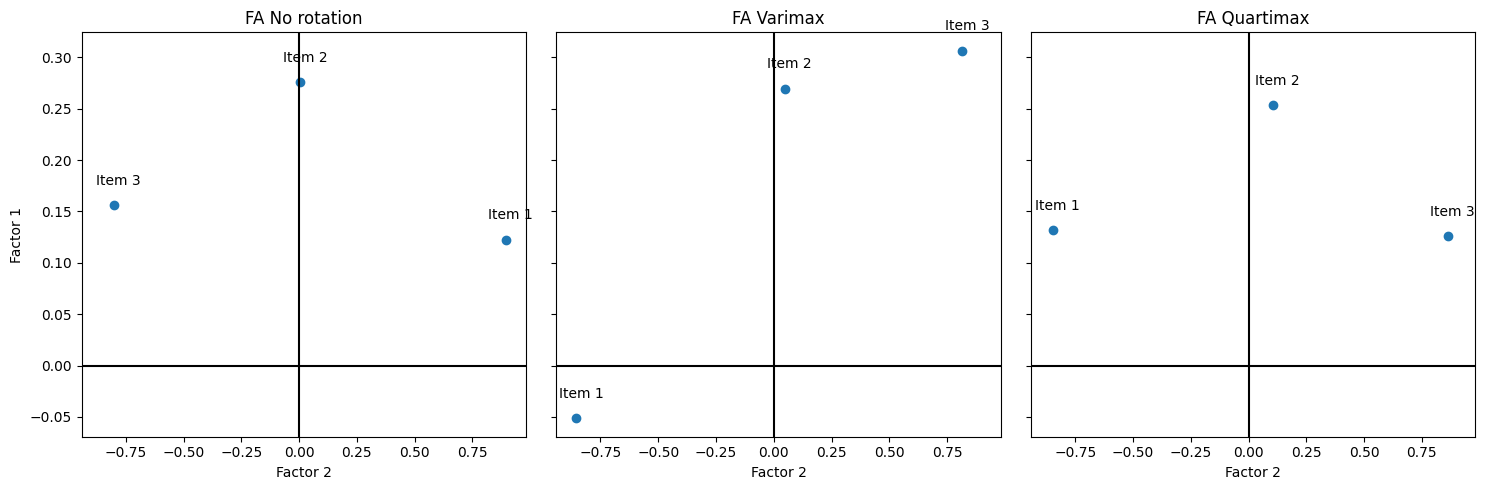

In [63]:
factor_df=pd.DataFrame(fa.loadings_,index=dfc.columns)
factor_df = factor_df.iloc[0:100]
methods = [
    ("FA No rotation", FactorAnalyzer(2,)),
    ("FA Varimax", FactorAnalyzer(2, rotation="varimax")),
    ("FA Quartimax", FactorAnalyzer(2, rotation="quartimax")),
]

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
for ax, (method, fa) in zip(axes, methods):
    fa.fit(factor_df)
    loadings = fa.loadings_ 
    ax.scatter(loadings[:, 0], loadings[:, 1])  
    ax.axhline(0, -1, 1, color='k')
    ax.axvline(0, -1, 1, color='k')
    
    for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
        ax.text(x + 0.02, y + 0.02, f"Item {i+1}", ha="center")
    ax.set_title(str(method))
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Factor 1")
    ax.set_xlabel("Factor 2")
plt.tight_layout()
plt.show()

#### hasil

In [64]:
# Ambil faktor yang mempunyai nilai eigen > 2
fa = FactorAnalyzer(n_factors=3,rotation='varimax')
fa.fit(dfc)

loadings = fa.loadings_
factor_df=pd.DataFrame(fa.loadings_,index=dfc.columns)
factor_df

,0,1,2
AD1,0.006376,-0.018038,-0.002442
AD2,-0.011639,0.018298,0.006683
AD3,0.000713,-0.005414,0.008825
AD4,-0.016376,-0.006036,0.002603
AD5,0.023507,0.010222,0.011399
...,...,...,...
TL_1,0.440990,0.012213,0.160662
TL_2,0.500276,0.037215,0.175527
TL_3,0.443204,0.069248,0.213305
TL_4,0.505500,0.044504,0.182415


In [65]:
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(dfc)
factor_loadings = fa.loadings_
eigenvalues, communalities = fa.get_eigenvalues()

with np.printoptions(suppress = True, precision =5):
    pd.DataFrame(fa.loadings_, index=dfc.columns)
print("Communalities:")
print(communalities)

Communalities:
[ 3.53893809e+01  1.27465697e+01  2.55124113e+00  1.18501642e+00
  8.78059644e-01  8.20050127e-01  7.92636136e-01  6.92970289e-01
  5.99903437e-01  5.98283187e-01  5.63061171e-01  5.58467421e-01
  5.04365032e-01  4.64970789e-01  4.50432020e-01  4.26866403e-01
  3.88414103e-01  3.66853954e-01  3.54521916e-01  3.42571848e-01
  3.28131876e-01  3.19103419e-01  2.97725876e-01  2.73213797e-01
  2.65602873e-01  2.49327654e-01  2.40266434e-01  2.29000015e-01
  2.18332998e-01  2.07972228e-01  2.06198720e-01  1.94751631e-01
  1.86538779e-01  1.76974697e-01  1.56314866e-01  1.52829413e-01
  1.52494932e-01  1.47161593e-01  1.37740883e-01  1.35597872e-01
  1.30378789e-01  1.25491260e-01  1.15926468e-01  1.09724027e-01
  1.05188638e-01  1.01514147e-01  9.20905899e-02  9.02586975e-02
  8.28357359e-02  7.82065503e-02  7.33740803e-02  6.70657246e-02
  6.36545415e-02  6.17803247e-02  5.72145180e-02  5.21173479e-02
  4.68339695e-02  4.14320928e-02  3.98501111e-02  3.43728411e-02
  3.254852

In [66]:
import numpy as np
import pandas as pd

columns = [
    'AD1', 'AD2', 'AD3', 'AD4', 'AD5', 'AD6', 'AD7', 'AD8',
    'AKM1', 'AKM2', 'AKM3', 'AKM4', 'AKM5', 'AKM6', 'AKM7', 'AKM8',
    'AKM9', 'AKM10', 'AKM11', 'AKM12', 'AKM13', 'AKM14', 'AKM15', 'AKM16',
    'AKP1', 'AKP2', 'AKP3', 'AKP4', 'AKP5', 'AKP6', 'AKP7', 'AKP8',
    'AKP9', 'AKP10', 'AKJ1', 'AKJ2', 'AKJ3', 'AKJ4', 'AKJ5', 'AKJ6', 
    'AKJ7', 'AKJ8', 'AKJ9', 'AKJ10', 'AKU1', 'AKU2', 'AKU3', 'AKU4', 
    'AKU5', 'AKU6', 'AKU7', 'AKU8', 'AKU9', 'AKU10', 'AU1', 'AU2', 
    'AU3', 'AU4', 'AU5', 'AU6', 'AU7', 'AU8', 'AU9', 'AU10', 'KT1', 
    'KT2', 'KT3', 'KT4', 'KT5', 'KT6', 'KT7', 'KT8', 'KS1', 'KS2', 
    'KS3', 'KS4', 'KS5', 'KS6', 'KS7', 'KS8', 'KS9', 'DR1', 'DR2', 
    'DR3', 'DR4', 'DR5', 'DR6', 'DR7', 'DR8', 'DR9', 'DR10', 'LKA1', 
    'LKA2', 'LKA3', 'LKA4', 'LKA5', 'LKA6', 'LKA7', 'LKA8', 'LKA9', 
    'LP1', 'LP2', 'LP3', 'LP4', 'LP5', 'LP6', 'LP7', 'LP8', 'LP9', 
    'LK1', 'LK2', 'ML1', 'MIS1', 'MIS2', 'MIS3', 'P3_1', 'P3_2', 
    'P3_3', 'P3_4', 'P3_5', 'P3_6', 'P3_7', 'P3_8', 'P3_9', 
    'P3_10', 'P4_1', 'P4_2', 'P4_3', 'P4_4', 'P4_5', 'P4_6', 
    'P4_7', 'P4_8', 'P4_9', 'P4_10', 'PS_1', 'PS_2', 'PS_3', 
    'PS_4', 'PS_5', 'PS_6', 'PS_7', 'PS_8', 'PS_9', 'PS_10', 
    'PJ_1', 'PJ_2', 'PJ_3', 'PJ_4', 'PW_1', 'PW_2', 'PW_3', 
    'PW_4', 'TL_1', 'TL_2', 'TL_3', 'TL_4', 'TL_5'
]
X = np.random.rand(158, len(columns))
df = pd.DataFrame(X, columns=columns)
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(df)
factor_loadings = fa.loadings_

faktor1 = []
faktor2 = []
faktor3 = []

for i, x in enumerate(factor_loadings):
    if max(x) == x[0]:
        faktor1.append(df.columns[i])  
    elif max(x) == x[1]:
        faktor2.append(df.columns[i])  
    else:
        faktor3.append(df.columns[i])  
print(f"Faktor 1: {faktor1}")
print(f"Faktor 2: {faktor2}")
print(f"Faktor 3: {faktor3}")

Faktor 1: ['AD4', 'AKM1', 'AKM2', 'AKM3', 'AKM5', 'AKM9', 'AKM12', 'AKM13', 'AKM14', 'AKP2', 'AKP7', 'AKJ2', 'AKJ7', 'AKJ9', 'AKU1', 'AKU2', 'AKU4', 'AKU5', 'AKU7', 'AKU10', 'AU6', 'AU8', 'AU9', 'KT5', 'KT8', 'KS3', 'KS7', 'KS8', 'KS9', 'DR4', 'DR9', 'DR10', 'LKA1', 'LKA5', 'LKA7', 'LKA9', 'LP3', 'LP7', 'ML1', 'P3_1', 'P3_6', 'P3_9', 'P3_10', 'P4_4', 'P4_5', 'P4_7', 'P4_8', 'P4_9', 'PS_3', 'PW_1', 'PW_2', 'TL_4', 'TL_5']
Faktor 2: ['AD5', 'AD7', 'AD8', 'AKM4', 'AKM11', 'AKP1', 'AKP3', 'AKJ1', 'AKJ3', 'AKJ4', 'AKJ5', 'AKJ6', 'AKJ8', 'AKJ10', 'AU1', 'AU3', 'AU10', 'KT1', 'KT2', 'KT4', 'KT6', 'KS2', 'KS4', 'KS6', 'DR1', 'DR5', 'DR8', 'LKA4', 'LP2', 'LP4', 'LP5', 'LP6', 'LP9', 'LK1', 'MIS2', 'MIS3', 'P3_3', 'P3_7', 'P4_3', 'P4_6', 'PS_2', 'PS_6', 'PS_7', 'PS_8', 'PS_10', 'PJ_1', 'PJ_3', 'PW_3', 'PW_4', 'TL_1', 'TL_2', 'TL_3']
Faktor 3: ['AD1', 'AD2', 'AD3', 'AD6', 'AKM6', 'AKM7', 'AKM8', 'AKM10', 'AKM15', 'AKM16', 'AKP4', 'AKP5', 'AKP6', 'AKP8', 'AKP9', 'AKP10', 'AKU3', 'AKU6', 'AKU8', 'AK

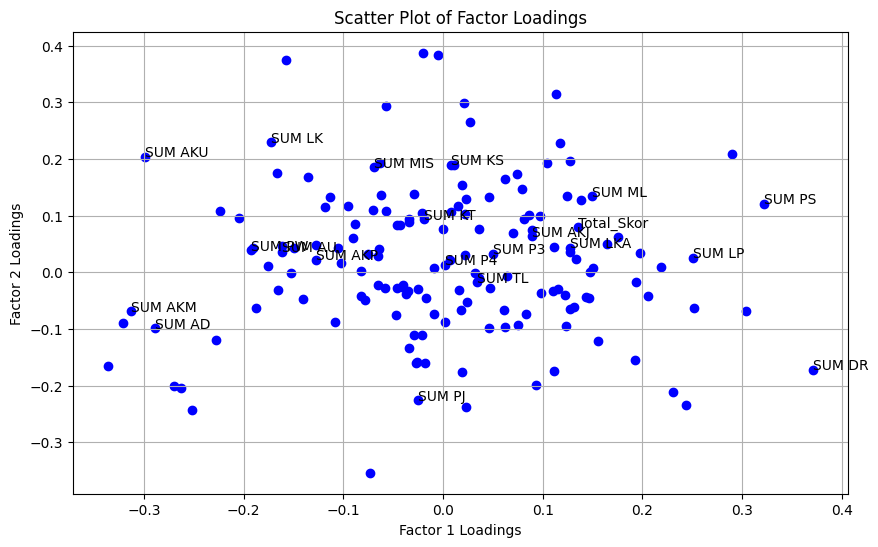

In [67]:
factor_loadings = fa.loadings_
plt.figure(figsize=(10, 6))
plt.scatter(factor_loadings[:, 0], factor_loadings[:, 1], c='b', marker='o')
plt.xlabel('Factor 1 Loadings')
plt.ylabel('Factor 2 Loadings')
plt.title('Scatter Plot of Factor Loadings')
plt.grid(True)

for i, txt in enumerate(dfq.columns):
    plt.annotate(txt, (factor_loadings[i, 0], factor_loadings[i, 1]))
plt.show()

#### panjaanggg

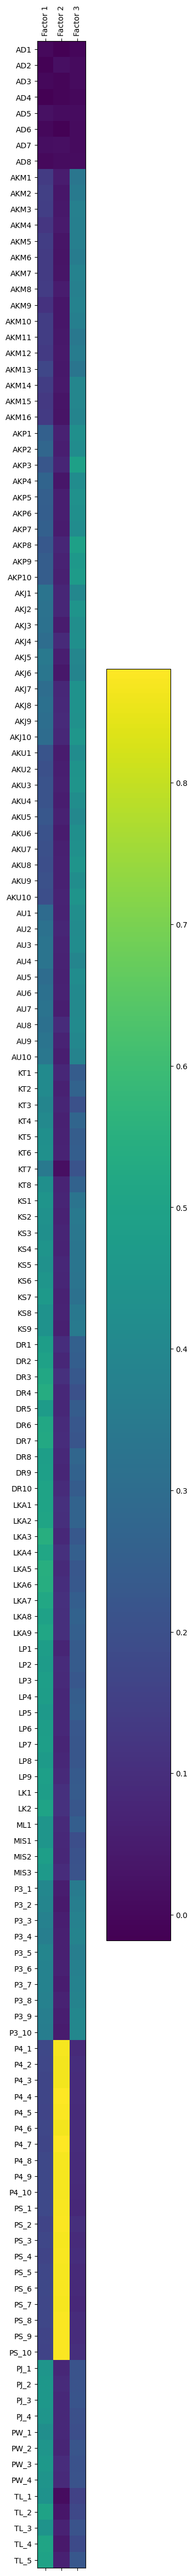

In [68]:
fig, ax = plt.subplots(figsize=(10, 60))  
cax = ax.matshow(factor_df, cmap='viridis') 
fig.colorbar(cax)

ax.set_xticks(range(len(factor_df.columns)))
ax.set_yticks(range(len(factor_df.index)))
ax.set_xticklabels(['Factor 1', 'Factor 2', 'Factor 3'], rotation=90) 
ax.set_yticklabels(factor_df.index)
plt.show()

#### DATA

In [69]:
df_trans = df_combi.transpose()
df_trans.head()

,0,1,2,3,4,5,6,7,8,9,...,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919
AD1,3,3,3,3,3,3,3,4,3,3,...,3,3,4,4,3,4,2,4,4,3
AD2,3,3,4,4,3,4,3,4,3,3,...,3,4,3,3,3,3,4,3,4,3
AD3,3,2,4,3,3,3,2,3,3,3,...,3,3,3,3,3,3,3,3,3,3
AD4,4,3,2,4,3,3,4,3,3,3,...,3,4,3,3,3,3,3,3,3,3
AD5,3,3,3,4,4,3,3,3,3,3,...,3,4,4,4,4,3,3,3,3,3


In [70]:
data3 = dfc.transpose()
data3

,0,1,2,3,4,5,6,7,8,9,...,3228,3229,3230,3231,3232,3233,3234,3235,3236,3237
AD1,3,3,3,3,3,3,3,4,3,3,...,3,3,3,3,4,4,3,3,3,4
AD2,3,3,4,4,3,4,3,4,3,3,...,3,4,4,3,3,4,3,3,3,3
AD3,3,2,4,3,3,3,2,3,3,3,...,3,3,3,3,3,3,3,4,3,3
AD4,4,3,2,4,3,3,4,3,3,3,...,3,2,3,3,3,3,3,3,4,3
AD5,3,3,3,4,4,3,3,3,3,3,...,3,3,3,3,3,2,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TL_1,3,3,4,3,3,4,3,4,3,3,...,0,0,0,0,0,0,0,0,0,0
TL_2,3,3,4,3,3,4,3,4,3,3,...,0,0,0,0,0,0,0,0,0,0
TL_3,3,3,3,4,3,3,3,3,3,4,...,0,0,0,0,0,0,0,0,0,0
TL_4,3,4,4,3,3,4,3,4,3,3,...,0,0,0,0,0,0,0,0,0,0


#### ELBOW

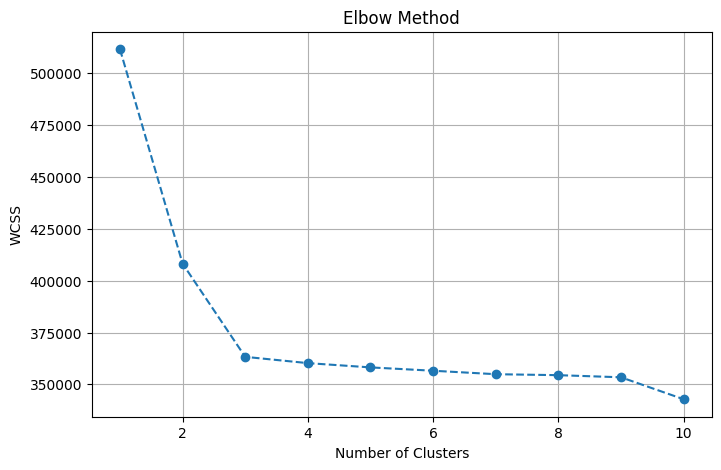

In [71]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dfc)
wcss = []  # Within-Cluster-Sum-of-Squares
max_clusters = 10 

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

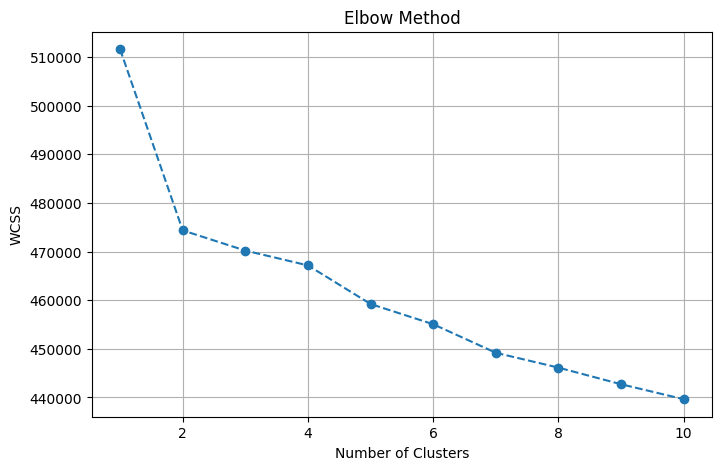

In [72]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data3)
wcss = []  # Within-Cluster-Sum-of-Squares
max_clusters = 10  

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

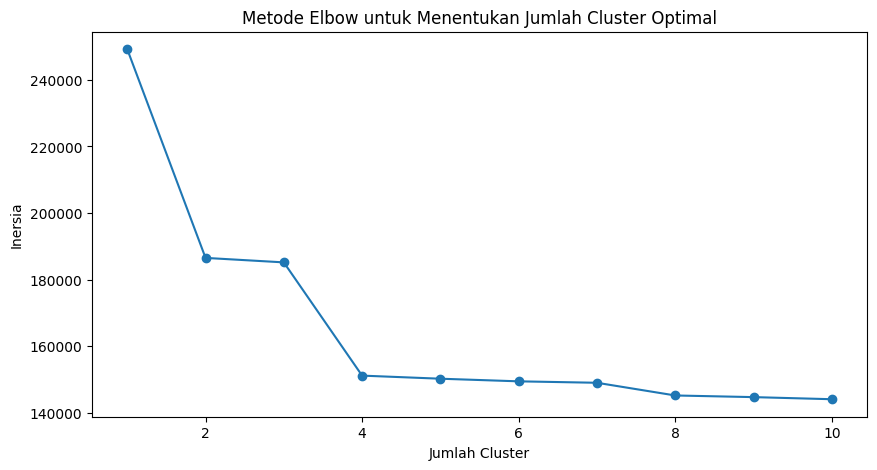

In [73]:
# Menghitung inersia untuk jumlah cluster 1 hingga 10
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(dfc)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inersia')
plt.show()

### Cluster

In [74]:
model = KMeans(n_clusters=3)
model.fit(data3)

KMeans(n_clusters=3)

In [75]:
data3

,0,1,2,3,4,5,6,7,8,9,...,3228,3229,3230,3231,3232,3233,3234,3235,3236,3237
AD1,3,3,3,3,3,3,3,4,3,3,...,3,3,3,3,4,4,3,3,3,4
AD2,3,3,4,4,3,4,3,4,3,3,...,3,4,4,3,3,4,3,3,3,3
AD3,3,2,4,3,3,3,2,3,3,3,...,3,3,3,3,3,3,3,4,3,3
AD4,4,3,2,4,3,3,4,3,3,3,...,3,2,3,3,3,3,3,3,4,3
AD5,3,3,3,4,4,3,3,3,3,3,...,3,3,3,3,3,2,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TL_1,3,3,4,3,3,4,3,4,3,3,...,0,0,0,0,0,0,0,0,0,0
TL_2,3,3,4,3,3,4,3,4,3,3,...,0,0,0,0,0,0,0,0,0,0
TL_3,3,3,3,4,3,3,3,3,3,4,...,0,0,0,0,0,0,0,0,0,0
TL_4,3,4,4,3,3,4,3,4,3,3,...,0,0,0,0,0,0,0,0,0,0


#### admin

In [76]:
ADMINISTRASI = data3.iloc[0:64]
ADMINISTRASI.columns = ADMINISTRASI.columns.astype(str)
k_means_admin = model.fit_predict(ADMINISTRASI)
k_means_admin

array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0])

In [77]:
ADMINISTRASI['Total Bobot'] = ADMINISTRASI.iloc[:, :3238].sum(axis=1)
ADMINISTRASI['Cluster'] = k_means_admin
mean_bobot_per_klaster = ADMINISTRASI.groupby('Cluster')['Total Bobot'].mean()
mean_bobot_sorted = mean_bobot_per_klaster.sort_values(ascending=False)
mapping_klaster = {mean_bobot_sorted.index[0]: "Tinggi", 
                   mean_bobot_sorted.index[1]: "Sedang", 
                   mean_bobot_sorted.index[2]: "Rendah"}
ADMINISTRASI['Label Klaster'] = ADMINISTRASI['Cluster'].map(mapping_klaster)
ADMINISTRASI['LAYANAN'] = 'ADMINISTRASI'

def map_prefix_to_name(prefix):
    if prefix.startswith('AD'):
        return 'ADMINISTASI AKADEMIK'
    elif prefix.startswith('AKM'):
        return 'ADMINISTRASI KEMAHASISWAAN'
    elif prefix.startswith('AKP'):
        return 'ADMINISTRASI KEPEGAWAIAN'
    elif prefix.startswith('AKJ'):
        return 'ADMINISTRASI KERJASAMA'
    elif prefix.startswith('AKU'):
        return 'ADMINISTRASI KEUANGAN'
    elif prefix.startswith('AU'):
        return 'ADMINISTRASI UMUM'
    return 'Unknown'
ADMINISTRASI['DETAIL'] = ADMINISTRASI.index.to_series().apply(map_prefix_to_name)
criteria_mapping = {
    'AD1': 'Kecepatan dalam melayani',
    'AD2': 'Ketrampilan petugas dalam melayani',
    'AD3': 'Persyaratan pelayanan jelas',
    'AD4': 'Petugas disiplin terhadap waktu pelayanan',
    'AD5': 'Petugas yang melayani jelas',
    'AD6': 'Prosedur pelayanan mudah (diketahui)',
    'AD7': 'Sikap dan perilaku (perilaku) petugas',
    'AD8': 'Tanggung jawab dan empati petugas',

    'AKM1': 'Kecepatan dalam melayani',
    'AKM2': 'Ketrampilan petugas dalam melayani',
    'AKM3': 'Layanan akses informasi sistem seleksi mahasiswa baru',
    'AKM4': 'Layanan karir dan bimbingan kewirausahaan',
    'AKM5': 'Layanan kesejahteraan dan layanan kesehatan',
    'AKM6': 'Layanan minat dan bakat termasuk kegiatan mahasiswa dan UKM',
    'AKM7': 'Layanan penalaran, dan softskills',
    'AKM8': 'Layanan proses registrasi mahasiswa baru',
    'AKM9': 'Penataan sarana rapi',
    'AKM10': 'Persyaratan pelayanan jelas',
    'AKM11': 'Petugas disiplin terhadap waktu pelayanan',
    'AKM12': 'Petugas yang melayani jelas',
    'AKM13': 'Prosedur pelayanan mudah (diketahui)',
    'AKM14': 'Ruangan bersih',
    'AKM15': 'Sikap dan perilaku (perilaku) petugas',
    'AKM16': 'Tanggung jawab dan empati petugas',

    'AKP1': 'Kecepatan dalam melayani',
    'AKP2': 'Ketrampilan petugas dalam melayani',
    'AKP3': 'Penataan sarana rapi',
    'AKP4': 'Persyaratan pelayanan jelas',
    'AKP5': 'Petugas disiplin terhadap waktu pelayanan',
    'AKP6': 'Petugas yang melayani jelas',
    'AKP7': 'Prosedur pelayanan mudah (diketahui)',
    'AKP8': 'Ruangan bersih',
    'AKP9': 'Sikap dan perilaku (perilaku) petugas',
    'AKP10': 'Tanggung jawab dan empati petugas',

    'AKJ1': 'Kecepatan dalam melayani',
    'AKJ2': 'Ketrampilan petugas dalam melayani',
    'AKJ3': 'Penataan sarana rapi',
    'AKJ4': 'Persyaratan pelayanan jelas',
    'AKJ5': 'Petugas disiplin terhadap waktu pelayanan',
    'AKJ6': 'Petugas yang melayani jelas',
    'AKJ7': 'Prosedur pelayanan mudah (diketahui)',
    'AKJ8': 'Ruangan bersih',
    'AKJ9': 'Sikap dan perilaku (perilaku) petugas',
    'AKJ10': 'Tanggung jawab dan empati petugas',

    'AKU1': 'Kecepatan dalam melayani',
    'AKU2': 'Ketrampilan petugas dalam melayani',
    'AKU3': 'Penataan sarana rapi',
    'AKU4': 'Persyaratan pelayanan jelas',
    'AKU5': 'Petugas disiplin terhadap waktu pelayanan',
    'AKU6': 'Petugas yang melayani jelas',
    'AKU7': 'Prosedur pelayanan mudah (diketahui)',
    'AKU8': 'Ruangan bersih',
    'AKU9': 'Sikap dan perilaku (perilaku) petugas',
    'AKU10': 'Tanggung jawab dan empati petugas',

    'AU1': 'Kecepatan dalam melayani',
    'AU2': 'Ketrampilan petugas dalam melayani',
    'AU3': 'Penataan sarana rapi',
    'AU4': 'Persyaratan pelayanan jelas',
    'AU5': 'Petugas disiplin terhadap waktu pelayanan',
    'AU6': 'Petugas yang melayani jelas',
    'AU7': 'Prosedur pelayanan mudah (diketahui)',
    'AU8': 'Ruangan bersih',
    'AU9': 'Sikap dan perilaku (perilaku) petugas',
    'AU10': 'Tanggung jawab dan empati petugas',
}
def get_kriteria(row):
    for code, criteria in criteria_mapping.items():
        if code in row.name:
            return criteria
    return 'Unknown'
ADMINISTRASI['KRITERIA'] = ADMINISTRASI.apply(get_kriteria, axis=1)

ADMINISTRASI.to_csv('data/ADMIN.csv', index=False)
ADMINISTRASI

C:\Users\User\AppData\Local\Temp\ipykernel_20856\4076143138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADMINISTRASI['Total Bobot'] = ADMINISTRASI.iloc[:, :3238].sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_20856\4076143138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADMINISTRASI['Cluster'] = k_means_admin
C:\Users\User\AppData\Local\Temp\ipykernel_20856\4076143138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,0,1,2,3,4,5,6,7,8,9,...,3234,3235,3236,3237,Total Bobot,Cluster,Label Klaster,LAYANAN,DETAIL,KRITERIA
AD1,3,3,3,3,3,3,3,4,3,3,...,3,3,3,4,10253,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Kecepatan dalam melayani
AD2,3,3,4,4,3,4,3,4,3,3,...,3,3,3,3,10408,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Ketrampilan petugas dalam melayani
AD3,3,2,4,3,3,3,2,3,3,3,...,3,4,3,3,10327,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Persyaratan pelayanan jelas
AD4,4,3,2,4,3,3,4,3,3,3,...,3,3,4,3,10292,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Petugas disiplin terhadap waktu pelayanan
AD5,3,3,3,4,4,3,3,3,3,3,...,3,3,3,4,10294,0,Rendah,ADMINISTRASI,ADMINISTASI AKADEMIK,Petugas yang melayani jelas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AU6,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,10303,0,Rendah,ADMINISTRASI,ADMINISTRASI UMUM,Petugas yang melayani jelas
AU7,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,10295,1,Sedang,ADMINISTRASI,ADMINISTRASI UMUM,Prosedur pelayanan mudah (diketahui)
AU8,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,10356,1,Sedang,ADMINISTRASI,ADMINISTRASI UMUM,Ruangan bersih
AU9,3,3,3,3,3,3,3,4,4,3,...,0,0,0,0,10314,1,Sedang,ADMINISTRASI,ADMINISTRASI UMUM,Sikap dan perilaku (perilaku) petugas


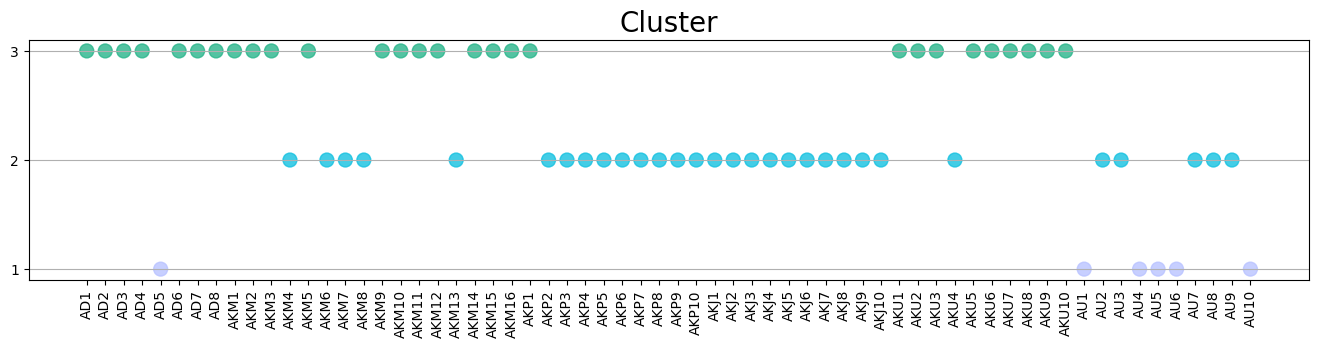

In [78]:
colors = ['#B9C3FF', '#14C1E0', '#29b58b']
cmap = ListedColormap(colors)

plt.figure(figsize=(16, 3))
plt.scatter(ADMINISTRASI.index,ADMINISTRASI['Cluster'], c=ADMINISTRASI['Cluster'], cmap=cmap, s=100, alpha=0.8)
plt.title('Cluster', fontsize=20)
plt.xticks(rotation=90)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.tick_params(axis='y', labelsize=15)
plt.yticks([0,1,2], ['1', '2','3'], fontsize=10)
plt.grid(True, which='major', axis='y')
plt.show()

#### pusat terpadu

In [79]:
PUSAT_TERPADU = data3.iloc[64:109]
PUSAT_TERPADU.columns = PUSAT_TERPADU.columns.astype(str)
k_means_pt = model.fit_predict(PUSAT_TERPADU)
k_means_pt

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2,
       1])

In [80]:
PUSAT_TERPADU['Total Bobot'] = PUSAT_TERPADU.iloc[:, :3238].sum(axis=1)
PUSAT_TERPADU['Cluster'] = k_means_pt
mean_bobot_per_klaster = PUSAT_TERPADU.groupby('Cluster')['Total Bobot'].mean()
mean_bobot_sorted = mean_bobot_per_klaster.sort_values(ascending=False)
mapping_klaster = {mean_bobot_sorted.index[0]: "Tinggi", 
                   mean_bobot_sorted.index[1]: "Sedang", 
                   mean_bobot_sorted.index[2]: "Rendah"}
PUSAT_TERPADU['Label Klaster'] = PUSAT_TERPADU['Cluster'].map(mapping_klaster)
PUSAT_TERPADU['LAYANAN'] = 'PUSAT TERPADU'

def map_prefix_to_name(prefix):
    if prefix.startswith('KT'):
        return 'KANTIN'
    elif prefix.startswith('KS'):
        return 'KESEKRETARIATAN'
    elif prefix.startswith('DR'):
        return 'LAYANAN DOKTER KAMPUS'
    elif prefix.startswith('LKA'):
        return 'LAYANAN KEAMANAN'
    elif prefix.startswith('LP'):
        return 'LAYANAN PARKIR'
    return 'Unknown'
PUSAT_TERPADU['DETAIL'] = PUSAT_TERPADU.index.to_series().apply(map_prefix_to_name)
criteria_mapping = {
    'KT1': 'Kecepatan dalam melayani',
    'KT2': 'Ketrampilan petugas dalam melayani',
    'KT3': 'Penataan sarana rapi',
    'KT4': 'Persyaratan pelayanan jelas',
    'KT5': 'Petugas yang melayani jelas',
    'KT6': 'Prosedur pelayanan mudah (diketahui)',
    'KT7': 'Ruangan bersih',
    'KT8': 'Sikap dan perilaku (perilaku) petugas',

    'KS1': 'Kecepatan dalam melayani',
    'KS2': 'Ketrampilan petugas dalam melayani',
    'KS3': 'Persyaratan pelayanan jelas',
    'KS4': 'Petugas disiplin terhadap waktu pelayanan',
    'KS5': 'Petugas yang melayani jelas',
    'KS6': 'Prosedur pelayanan mudah (diketahui)',
    'KS7': 'Ruangan bersih',
    'KS8': 'Sikap dan perilaku (perilaku) petugas',
    'KS9': 'Tanggung jawab dan empati petugas',

    'DR1': 'Kecepatan dalam melayani',
    'DR2': 'Ketrampilan petugas dalam melayani',
    'DR3': 'Penataan sarana rapi',
    'DR4': 'Persyaratan pelayanan jelas',
    'DR5': 'Petugas disiplin terhadap waktu pelayanan',
    'DR6': 'Petugas yang melayani jelas',
    'DR7': 'Prosedur pelayanan mudah (diketahui)',
    'DR8': 'Ruangan bersih',
    'DR9': 'Sikap dan perilaku (perilaku) petugas',
    'DR10': 'Tanggung jawab dan empati petugas',

    'LKA1': 'Kecepatan dalam melayani',
    'LKA2': 'Ketrampilan petugas dalam melayani',
    'LKA3': 'Persyaratan pelayanan jelas',
    'LKA4': 'Petugas disiplin terhadap waktu pelayanan',
    'LKA5': 'Petugas yang melayani jelas',
    'LKA6': 'Prosedur pelayanan mudah (diketahui)',
    'LKA7': 'Ruangan bersih',
    'LKA8': 'Sikap dan perilaku (perilaku) petugas',
    'LKA9': 'Tanggung jawab dan empati petugas',

    'LP1': 'Kecepatan dalam melayani',
    'LP2': 'Ketrampilan petugas dalam melayani',
    'LP3': 'Persyaratan pelayanan jelas',
    'LP4': 'Petugas disiplin terhadap waktu pelayanan',
    'LP5': 'Petugas yang melayani jelas',
    'LP6': 'Prosedur pelayanan mudah (diketahui)',
    'LP7': 'Ruangan bersih',
    'LP8': 'Sikap dan perilaku (perilaku) petugas',
    'LP9': 'Tanggung jawab dan empati petugas',
}
def get_kriteria(row):
    for code, criteria in criteria_mapping.items():
        if code in row.name:
            return criteria
    return 'Unknown'
PUSAT_TERPADU['KRITERIA'] = PUSAT_TERPADU.apply(get_kriteria, axis=1)

PUSAT_TERPADU.to_csv('data/PUTER.csv', index=False)
PUSAT_TERPADU.tail()

C:\Users\User\AppData\Local\Temp\ipykernel_20856\860365984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PUSAT_TERPADU['Total Bobot'] = PUSAT_TERPADU.iloc[:, :3238].sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_20856\860365984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PUSAT_TERPADU['Cluster'] = k_means_pt
C:\Users\User\AppData\Local\Temp\ipykernel_20856\860365984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,0,1,2,3,4,5,6,7,8,9,...,3234,3235,3236,3237,Total Bobot,Cluster,Label Klaster,LAYANAN,DETAIL,KRITERIA
LP5,3,3,4,3,3,3,3,3,3,3,...,0,0,0,0,10110,1,Tinggi,PUSAT TERPADU,LAYANAN PARKIR,Petugas yang melayani jelas
LP6,3,2,3,3,3,3,3,3,3,4,...,0,0,0,0,10076,2,Sedang,PUSAT TERPADU,LAYANAN PARKIR,Prosedur pelayanan mudah (diketahui)
LP7,3,3,3,3,3,3,3,4,3,3,...,0,0,0,0,10051,2,Sedang,PUSAT TERPADU,LAYANAN PARKIR,Ruangan bersih
LP8,3,3,3,3,3,3,3,3,4,3,...,0,0,0,0,10053,2,Sedang,PUSAT TERPADU,LAYANAN PARKIR,Sikap dan perilaku (perilaku) petugas
LP9,3,3,3,3,3,3,3,3,4,3,...,0,0,0,0,10104,1,Tinggi,PUSAT TERPADU,LAYANAN PARKIR,Tanggung jawab dan empati petugas


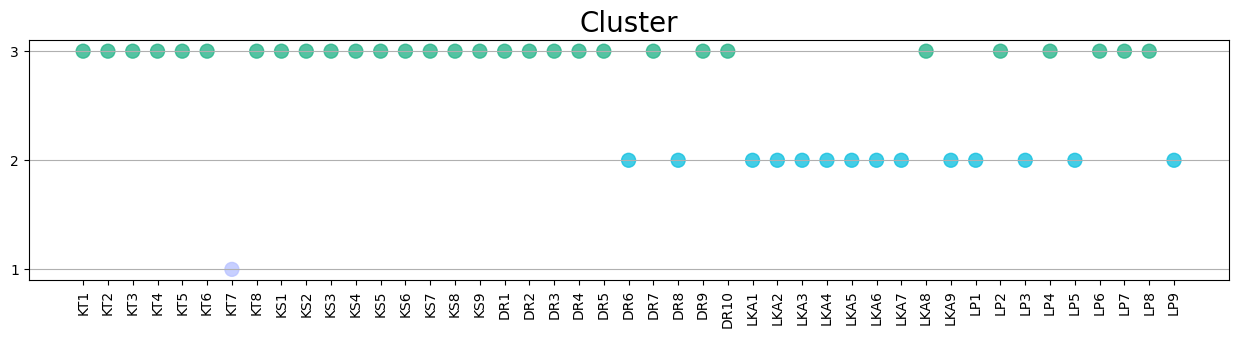

In [81]:
colors = ['#B9C3FF', '#14C1E0', '#29b58b']
cmap = ListedColormap(colors)

plt.figure(figsize=(15, 3))
plt.scatter(PUSAT_TERPADU.index,PUSAT_TERPADU['Cluster'], c=PUSAT_TERPADU['Cluster'], cmap=cmap, s=100, alpha=0.8)
plt.title('Cluster', fontsize=20)
plt.xticks(rotation=90)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.tick_params(axis='y', labelsize=15)
plt.yticks([0,1,2], ['1', '2','3'], fontsize=10)
plt.grid(True, which='major', axis='y')
plt.show()

#### perpustakaan

In [82]:
perpus = data3.iloc[115:145]
perpus.columns = perpus.columns.astype(str)
k_means_perpus = model.fit_predict(perpus)
k_means_perpus

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [83]:
perpus['Total Bobot'] = perpus.iloc[:, :3238].sum(axis=1)
perpus['Cluster'] = k_means_perpus

mean_bobot_per_klaster = perpus.groupby('Cluster')['Total Bobot'].mean()
mean_bobot_sorted = mean_bobot_per_klaster.sort_values(ascending=False)
mapping_klaster = {mean_bobot_sorted.index[0]: "Tinggi", 
                   mean_bobot_sorted.index[1]: "Sedang", 
                   mean_bobot_sorted.index[2]: "Rendah"}
perpus['Label Klaster'] = perpus['Cluster'].map(mapping_klaster)
perpus['LAYANAN'] = 'PERPUSTAKAAN'

def map_prefix_to_name(prefix):
    if prefix.startswith('P3'):
        return 'PERPUSTAKAAN GEDUNG D3'
    elif prefix.startswith('P4'):
        return 'PERPUSTAKAAN GEDUNG D4'
    elif prefix.startswith('PS'):
        return 'PERPUSTAKAAN GEDUNG PASCASARJANA'
    return 'Unknown'
perpus['DETAIL'] = perpus.index.to_series().apply(map_prefix_to_name)
criteria_mapping = {
    'P3_1': 'Kecepatan dalam melayani',
    'P3_2': 'Ketrampilan petugas dalam melayani',
    'P3_3': 'Penataan sarana rapi',
    'P3_4': 'Persyaratan pelayanan jelas',
    'P3_5': 'Petugas disiplin terhadap waktu pelayanan',
    'P3_6': 'Petugas yang melayani jelas',
    'P3_7': 'Prosedur pelayanan mudah (diketahui)',
    'P3_8': 'Ruangan bersih',
    'P3_9': 'Sikap dan perilaku (perilaku) petugas',
    'P3_10': 'Tanggung jawab dan empati petugas',

    'P4_1': 'Kecepatan dalam melayani',
    'P4_2': 'Ketrampilan petugas dalam melayani',
    'P4_3': 'Penataan sarana rapi',
    'P4_4': 'Persyaratan pelayanan jelas',
    'P4_5': 'Petugas disiplin terhadap waktu pelayanan',
    'P4_6': 'Petugas yang melayani jelas',
    'P4_7': 'Prosedur pelayanan mudah (diketahui)',
    'P4_8': 'Ruangan bersih',
    'P4_9': 'Sikap dan perilaku (perilaku) petugas',
    'P4_10': 'Tanggung jawab dan empati petugas',

    'PS_1': 'Kecepatan dalam melayani',
    'PS_2': 'Ketrampilan petugas dalam melayani',
    'PS_3': 'Penataan sarana rapi',
    'PS_4': 'Persyaratan pelayanan jelas',
    'PS_5': 'Petugas disiplin terhadap waktu pelayanan',
    'PS_6': 'Petugas yang melayani jelas',
    'PS_7': 'Prosedur pelayanan mudah (diketahui)',
    'PS_8': 'Ruangan bersih',
    'PS_9': 'Sikap dan perilaku (perilaku) petugas',
    'PS_10': 'Tanggung jawab dan empati petugas',
}
def get_kriteria(row):
    for code, criteria in criteria_mapping.items():
        if code in row.name:
            return criteria
    return 'Unknown'
perpus['KRITERIA'] = perpus.apply(get_kriteria, axis=1)

perpus.to_csv('data/PERPUS.csv', index=False)
perpus.head()

C:\Users\User\AppData\Local\Temp\ipykernel_20856\2901045964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perpus['Total Bobot'] = perpus.iloc[:, :3238].sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_20856\2901045964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perpus['Cluster'] = k_means_perpus
C:\Users\User\AppData\Local\Temp\ipykernel_20856\2901045964.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,0,1,2,3,4,5,6,7,8,9,...,3234,3235,3236,3237,Total Bobot,Cluster,Label Klaster,LAYANAN,DETAIL,KRITERIA
P3_1,3,4,3,3,3,3,3,3,4,4,...,0,0,0,0,10324,1,Sedang,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG D3,Kecepatan dalam melayani
P3_2,3,3,3,3,3,3,4,3,3,3,...,0,0,0,0,10351,1,Sedang,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG D3,Ketrampilan petugas dalam melayani
P3_3,4,3,3,3,3,3,4,4,3,3,...,0,0,0,0,10361,1,Sedang,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG D3,Penataan sarana rapi
P3_4,3,3,3,3,3,3,3,4,3,4,...,0,0,0,0,10342,1,Sedang,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG D3,Persyaratan pelayanan jelas
P3_5,3,3,3,3,4,3,3,3,3,4,...,0,0,0,0,10366,1,Sedang,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG D3,Petugas disiplin terhadap waktu pelayanan


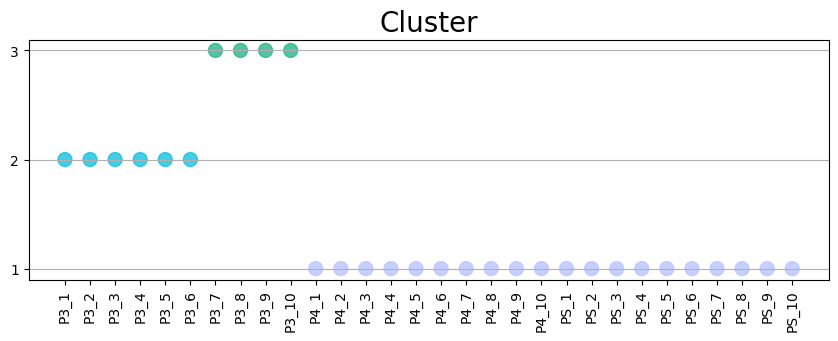

In [84]:
colors = ['#B9C3FF', '#14C1E0', '#29b58b']
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 3))
plt.scatter(perpus.index,perpus['Cluster'], c=perpus['Cluster'], cmap=cmap, s=100, alpha=0.8)
plt.title('Cluster', fontsize=20)
plt.xticks(rotation=90)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.tick_params(axis='y', labelsize=15)
plt.yticks([0,1,2], ['1', '2','3'], fontsize=10)
plt.grid(True, which='major', axis='y')
plt.show()

#### gabung

In [85]:
file1 = pd.read_csv('data/ADMIN.csv')
file2 = pd.read_csv('data/PUTER.csv')
file3 = pd.read_csv('data/PERPUS.csv')
klazter = pd.concat([file1, file2, file3], ignore_index=True)
klazter.to_csv('NEW_Cluster.csv', index=False)
klazter

,0,1,2,3,4,5,6,7,8,9,...,3234,3235,3236,3237,Total Bobot,Cluster,Label Klaster,LAYANAN,DETAIL,KRITERIA
0,3,3,3,3,3,3,3,4,3,3,...,3,3,3,4,10253,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Kecepatan dalam melayani
1,3,3,4,4,3,4,3,4,3,3,...,3,3,3,3,10408,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Ketrampilan petugas dalam melayani
2,3,2,4,3,3,3,2,3,3,3,...,3,4,3,3,10327,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Persyaratan pelayanan jelas
3,4,3,2,4,3,3,4,3,3,3,...,3,3,4,3,10292,2,Tinggi,ADMINISTRASI,ADMINISTASI AKADEMIK,Petugas disiplin terhadap waktu pelayanan
4,3,3,3,4,4,3,3,3,3,3,...,3,3,3,4,10294,0,Rendah,ADMINISTRASI,ADMINISTASI AKADEMIK,Petugas yang melayani jelas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,3,3,3,4,3,3,3,3,3,3,...,0,0,0,0,9626,0,Rendah,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG PASCASARJANA,Petugas yang melayani jelas
135,4,3,3,3,3,4,3,4,4,3,...,0,0,0,0,9625,0,Rendah,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG PASCASARJANA,Prosedur pelayanan mudah (diketahui)
136,3,3,3,4,3,3,3,4,3,4,...,0,0,0,0,9676,0,Rendah,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG PASCASARJANA,Ruangan bersih
137,3,3,3,2,4,3,3,4,3,3,...,0,0,0,0,9598,0,Rendah,PERPUSTAKAAN,PERPUSTAKAAN GEDUNG PASCASARJANA,Sikap dan perilaku (perilaku) petugas


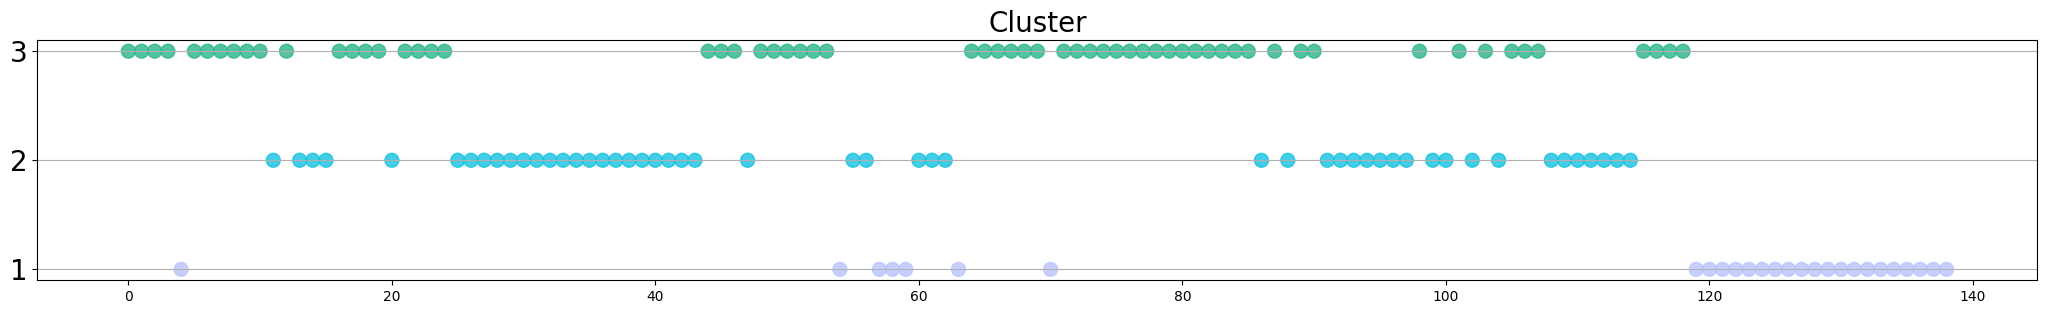

In [86]:
colors = ['#B9C3FF', '#14C1E0', '#29b58b']
cmap = ListedColormap(colors)

plt.figure(figsize=(25, 3))
plt.scatter(klazter.index,klazter['Cluster'], c=klazter['Cluster'], cmap=cmap, s=100, alpha=0.8)
plt.title('Cluster', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.tick_params(axis='y', labelsize=15)
plt.yticks([0,1,2], ['1', '2','3'], fontsize=20)
plt.grid(True, which='major', axis='y')
plt.show()

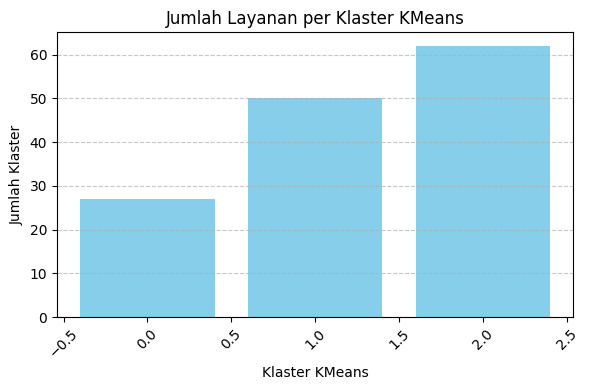

In [89]:
cluster_counts = klazter['Cluster'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Klaster KMeans')
plt.ylabel('Jumlah Klaster')
plt.title('Jumlah Layanan per Klaster KMeans')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [90]:
mean_bobot_per_klaster = klazter.groupby('Cluster')['Total Bobot'].mean()
mean_bobot_sorted = mean_bobot_per_klaster.sort_values(ascending=False)
mean_bobot_sorted

Cluster
1    10301.300000
2    10248.596774
0     9746.111111
Name: Total Bobot, dtype: float64

In [91]:
X = klazter[['Total Bobot']]
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

centroid_values = kmeans.cluster_centers_
print("Centroid tiap klaster berdasarkan Total Bobot:")
for i, centroid in enumerate(centroid_values):
    print(f"Klaster {i+1}: {centroid[0]}")

Centroid tiap klaster berdasarkan Total Bobot:
Klaster 1: 10326.858695652174
Klaster 2: 9588.772727272728
Klaster 3: 10103.96


In [87]:
# def map_prefix_to_name(prefix):
#     if prefix.startswith('AD'):
#         return 'ADMINISTASI AKADEMIK'
#     elif prefix.startswith('AKM'):
#         return 'ADMINISTRASI KEMAHASISWAAN'
#     elif prefix.startswith('AKP'):
#         return 'ADMINISTRASI KEPEGAWAIAN'
#     elif prefix.startswith('AKJ'):
#         return 'ADMINISTRASI KERJASAMA'
#     elif prefix.startswith('AKU'):
#         return 'ADMINISTRASI KEUANGAN'
#     elif prefix.startswith('AU'):
#         return 'ADMINISTRASI UMUM'
#     elif prefix.startswith('KT'):
#         return 'KANTIN'
#     elif prefix.startswith('KS'):
#         return 'KESEKRETARIATAN'
#     elif prefix.startswith('DR'):
#         return 'LAYANAN DOKTER KAMPUS'
#     elif prefix.startswith('LKA'):
#         return 'LAYANAN KEAMANAN'
#     elif prefix.startswith('LP'):
#         return 'LAYANAN PARKIR'
#     elif prefix.startswith('LK'):
#         return 'LINGKUNGAN KAMPUS'
#     elif prefix.startswith('ML'):
#         return 'MAILING LIST'
#     elif prefix.startswith('MIS'):
#         return 'MANAGEMENT INFORMATION SYSTEM (MIS)'
#     elif prefix.startswith('P3'):
#         return 'PERPUSTAKAAN GEDUNG D3'
#     elif prefix.startswith('P4'):
#         return 'PERPUSTAKAAN GEDUNG D4'
#     elif prefix.startswith('PS'):
#         return 'PERPUSTAKAAN GEDUNG PASCASARJANA'
#     elif prefix.startswith('PJ'):
#         return 'PORTAL JURUSAN/PRODI'
#     elif prefix.startswith('PW'):
#         return 'PORTAL WEB PENS'
#     elif prefix.startswith('TL'):
#         return 'TOILET'
#     return 'Unknown'

# datac['LAYANAN'] = datac.index.to_series().apply(map_prefix_to_name)
# datac

In [88]:
# criteria_mapping = {
#     'AD1': 'Kecepatan dalam melayani',
#     'AD2': 'Ketrampilan petugas dalam melayani',
#     'AD3': 'Persyaratan pelayanan jelas',
#     'AD4': 'Petugas disiplin terhadap waktu pelayanan',
#     'AD5': 'Petugas yang melayani jelas',
#     'AD6': 'Prosedur pelayanan mudah (diketahui)',
#     'AD7': 'Sikap dan perilaku (perilaku) petugas',
#     'AD8': 'Tanggung jawab dan empati petugas',

#     'AKM1': 'Kecepatan dalam melayani',
#     'AKM2': 'Ketrampilan petugas dalam melayani',
#     'AKM3': 'Layanan akses informasi sistem seleksi mahasiswa baru',
#     'AKM4': 'Layanan karir dan bimbingan kewirausahaan',
#     'AKM5': 'Layanan kesejahteraan dan layanan kesehatan',
#     'AKM6': 'Layanan minat dan bakat termasuk kegiatan mahasiswa dan UKM',
#     'AKM7': 'Layanan penalaran, dan softskills',
#     'AKM8': 'Layanan proses registrasi mahasiswa baru',
#     'AKM9': 'Penataan sarana rapi',
#     'AKM10': 'Persyaratan pelayanan jelas',
#     'AKM11': 'Petugas disiplin terhadap waktu pelayanan',
#     'AKM12': 'Petugas yang melayani jelas',
#     'AKM13': 'Prosedur pelayanan mudah (diketahui)',
#     'AKM14': 'Ruangan bersih',
#     'AKM15': 'Sikap dan perilaku (perilaku) petugas',
#     'AKM16': 'Tanggung jawab dan empati petugas',

#     'AKP1': 'Kecepatan dalam melayani',
#     'AKP2': 'Ketrampilan petugas dalam melayani',
#     'AKP3': 'Penataan sarana rapi',
#     'AKP4': 'Persyaratan pelayanan jelas',
#     'AKP5': 'Petugas disiplin terhadap waktu pelayanan',
#     'AKP6': 'Petugas yang melayani jelas',
#     'AKP7': 'Prosedur pelayanan mudah (diketahui)',
#     'AKP8': 'Ruangan bersih',
#     'AKP9': 'Sikap dan perilaku (perilaku) petugas',
#     'AKP10': 'Tanggung jawab dan empati petugas',

#     'AKJ1': 'Kecepatan dalam melayani',
#     'AKJ2': 'Ketrampilan petugas dalam melayani',
#     'AKJ3': 'Penataan sarana rapi',
#     'AKJ4': 'Persyaratan pelayanan jelas',
#     'AKJ5': 'Petugas disiplin terhadap waktu pelayanan',
#     'AKJ6': 'Petugas yang melayani jelas',
#     'AKJ7': 'Prosedur pelayanan mudah (diketahui)',
#     'AKJ8': 'Ruangan bersih',
#     'AKJ9': 'Sikap dan perilaku (perilaku) petugas',
#     'AKJ10': 'Tanggung jawab dan empati petugas',

#     'AKU1': 'Kecepatan dalam melayani',
#     'AKU2': 'Ketrampilan petugas dalam melayani',
#     'AKU3': 'Penataan sarana rapi',
#     'AKU4': 'Persyaratan pelayanan jelas',
#     'AKU5': 'Petugas disiplin terhadap waktu pelayanan',
#     'AKU6': 'Petugas yang melayani jelas',
#     'AKU7': 'Prosedur pelayanan mudah (diketahui)',
#     'AKU8': 'Ruangan bersih',
#     'AKU9': 'Sikap dan perilaku (perilaku) petugas',
#     'AKU10': 'Tanggung jawab dan empati petugas',

#     'AU1': 'Kecepatan dalam melayani',
#     'AU2': 'Ketrampilan petugas dalam melayani',
#     'AU3': 'Penataan sarana rapi',
#     'AU4': 'Persyaratan pelayanan jelas',
#     'AU5': 'Petugas disiplin terhadap waktu pelayanan',
#     'AU6': 'Petugas yang melayani jelas',
#     'AU7': 'Prosedur pelayanan mudah (diketahui)',
#     'AU8': 'Ruangan bersih',
#     'AU9': 'Sikap dan perilaku (perilaku) petugas',
#     'AU10': 'Tanggung jawab dan empati petugas',

#     'KT1': 'Kecepatan dalam melayani',
#     'KT2': 'Ketrampilan petugas dalam melayani',
#     'KT3': 'Penataan sarana rapi',
#     'KT4': 'Persyaratan pelayanan jelas',
#     'KT5': 'Petugas yang melayani jelas',
#     'KT6': 'Prosedur pelayanan mudah (diketahui)',
#     'KT7': 'Ruangan bersih',
#     'KT8': 'Sikap dan perilaku (perilaku) petugas',

#     'KS1': 'Kecepatan dalam melayani',
#     'KS2': 'Ketrampilan petugas dalam melayani',
#     'KS3': 'Persyaratan pelayanan jelas',
#     'KS4': 'Petugas disiplin terhadap waktu pelayanan',
#     'KS5': 'Petugas yang melayani jelas',
#     'KS6': 'Prosedur pelayanan mudah (diketahui)',
#     'KS7': 'Ruangan bersih',
#     'KS8': 'Sikap dan perilaku (perilaku) petugas',
#     'KS9': 'Tanggung jawab dan empati petugas',

#     'DR1': 'Kecepatan dalam melayani',
#     'DR2': 'Ketrampilan petugas dalam melayani',
#     'DR3': 'Penataan sarana rapi',
#     'DR4': 'Persyaratan pelayanan jelas',
#     'DR5': 'Petugas disiplin terhadap waktu pelayanan',
#     'DR6': 'Petugas yang melayani jelas',
#     'DR7': 'Prosedur pelayanan mudah (diketahui)',
#     'DR8': 'Ruangan bersih',
#     'DR9': 'Sikap dan perilaku (perilaku) petugas',
#     'DR10': 'Tanggung jawab dan empati petugas',

#     'LKA1': 'Kecepatan dalam melayani',
#     'LKA2': 'Ketrampilan petugas dalam melayani',
#     'LKA3': 'Persyaratan pelayanan jelas',
#     'LKA4': 'Petugas disiplin terhadap waktu pelayanan',
#     'LKA5': 'Petugas yang melayani jelas',
#     'LKA6': 'Prosedur pelayanan mudah (diketahui)',
#     'LKA7': 'Ruangan bersih',
#     'LKA8': 'Sikap dan perilaku (perilaku) petugas',
#     'LKA9': 'Tanggung jawab dan empati petugas',

#     'LP1': 'Kecepatan dalam melayani',
#     'LP2': 'Ketrampilan petugas dalam melayani',
#     'LP3': 'Persyaratan pelayanan jelas',
#     'LP4': 'Petugas disiplin terhadap waktu pelayanan',
#     'LP5': 'Petugas yang melayani jelas',
#     'LP6': 'Prosedur pelayanan mudah (diketahui)',
#     'LP7': 'Ruangan bersih',
#     'LP8': 'Sikap dan perilaku (perilaku) petugas',
#     'LP9': 'Tanggung jawab dan empati petugas',

#     'LK1': 'Lingkungan bersih',
#     'LK2': 'Penataan (taman, dll.)  bagus',

#     'ML1': 'Kecepatan akses',

#     'MIS1': 'Kecepatan akses',
#     'MIS2': 'Keragaman fitur/konten',
#     'MIS3': 'Konten/berita informatif',

#     'P3_1': 'Kecepatan dalam melayani',
#     'P3_2': 'Ketrampilan petugas dalam melayani',
#     'P3_3': 'Penataan sarana rapi',
#     'P3_4': 'Persyaratan pelayanan jelas',
#     'P3_5': 'Petugas disiplin terhadap waktu pelayanan',
#     'P3_6': 'Petugas yang melayani jelas',
#     'P3_7': 'Prosedur pelayanan mudah (diketahui)',
#     'P3_8': 'Ruangan bersih',
#     'P3_9': 'Sikap dan perilaku (perilaku) petugas',
#     'P3_10': 'Tanggung jawab dan empati petugas',

#     'P4_1': 'Kecepatan dalam melayani',
#     'P4_2': 'Ketrampilan petugas dalam melayani',
#     'P4_3': 'Penataan sarana rapi',
#     'P4_4': 'Persyaratan pelayanan jelas',
#     'P4_5': 'Petugas disiplin terhadap waktu pelayanan',
#     'P4_6': 'Petugas yang melayani jelas',
#     'P4_7': 'Prosedur pelayanan mudah (diketahui)',
#     'P4_8': 'Ruangan bersih',
#     'P4_9': 'Sikap dan perilaku (perilaku) petugas',
#     'P4_10': 'Tanggung jawab dan empati petugas',

#     'PS_1': 'Kecepatan dalam melayani',
#     'PS_2': 'Ketrampilan petugas dalam melayani',
#     'PS_3': 'Penataan sarana rapi',
#     'PS_4': 'Persyaratan pelayanan jelas',
#     'PS_5': 'Petugas disiplin terhadap waktu pelayanan',
#     'PS_6': 'Petugas yang melayani jelas',
#     'PS_7': 'Prosedur pelayanan mudah (diketahui)',
#     'PS_8': 'Ruangan bersih',
#     'PS_9': 'Sikap dan perilaku (perilaku) petugas',
#     'PS_10': 'Tanggung jawab dan empati petugas',

#     'PJ_1': 'Kecepatan akses',
#     'PJ_2': 'Keragaman fitur/konten',
#     'PJ_3': 'Konten/berita informatif',
#     'PJ_4': 'Konten/berita up-to-date',

#     'PW_1': 'Kecepatan akses',
#     'PW_2': 'Keragaman fitur/konten',
#     'PW_3': 'Konten/berita informatif',
#     'PW_4': 'Konten/berita up-to-date',

#     'TL_1': 'Bau',
#     'TL_2': 'Kebersihan closet',
#     'TL_3': 'Kebersihan ruangan toilet',
#     'TL_4': 'Kebersihan wastafel',
#     'TL_5': 'Persyaratan pelayanan jelas'
# }

# def get_kriteria(row):
#     for code, criteria in criteria_mapping.items():
#         if code in row.name:
#             return criteria
#     return 'Unknown'
# datac['KRITERIA'] = datac.apply(get_kriteria, axis=1)

#### TRASH

In [92]:
# pca = PCA()
# pca.fit(df_combinedall)

# explained_variance = pca.explained_variance_
# components = range(1, len(explained_variance) + 1)

# plt.figure(figsize=(8, 6))  # Adjust the figure size to match your example
# plt.plot(components, explained_variance, 'bo-', linewidth=2)  # blue circle markers connected by a line
# plt.title('Scree Plot')
# plt.xlabel('Factors')  # Adjust the label to match your example
# plt.ylabel('Eigenvalue')
# plt.grid(True)  # This adds a grid to the plot

# plt.axhline(y=1.1, color='red', linestyle='--')
# plt.show()

In [93]:
# data2['row_index'] = data2.groupby('NAMA_JENIS_KRITERIA').cumcount()
# df_pivoted = data2.pivot_table(index=data2.index, columns='NAMA_JENIS_KRITERIA', values='BOBOT', aggfunc='first')
# df_pivoted.reset_index(drop=True, inplace=True)
# df_pivoted

In [94]:
# df_pivoted = layanan_ad.pivot(index='NAMA_LAYANAN', columns='JENIS_KRITERIA', values='BOBOT')
# df_pivoted.reset_index(inplace=True)
# df_pivoted

In [95]:
# # layanan_jenis = pd.read_csv('total_bobot_layanan.csv')
# data1['JENIS_KRITERIA'] = data1.groupby('NAMA_LAYANAN').cumcount() + 1
# data1['JENIS_KRITERIA'] = data1['NAMA_LAYANAN'] + data1['JENIS_KRITERIA'].astype(str)
# data2 = data1.drop(columns=['NAMA_JENIS_KRITERIA'])
# data2 = data2[['NAMA_LAYANAN', 'JENIS_KRITERIA', 'BOBOT']]
# data2
# # data2.to_csv('layanan_jenis.csv', index=False)

In [96]:
# filtered_df = data1[(data1['NAMA_LAYANAN'] == 'AD') & (data1['NAMA_JENIS_KRITERIA'] == 'AD6')]
# count = filtered_df.shape[0]
# print(f'Number of rows matching the criteria: {count}')

In [97]:
# filtered_df = data1[(data1['NAMA_LAYANAN'] == 'PS')]
# counts = filtered_df['NAMA_JENIS_KRITERIA'].value_counts()
# print("Number of rows for each NAMA_JENIS_KRITERIA value:")
# print(counts)

In [98]:
# df = pd.read_csv('total_bobot_layanan.csv')
# # Create a mapping for the renaming
# criteria_mapping = {
#     'Kecepatan dalam melayani': 'AD1',    'Ketrampilan petugas dalam melayani': 'AD2',
#     'Persyaratan pelayanan jelas': 'AD3',    'Petugas disiplin terhadap waktu pelayanan': 'AD4',
#     'Petugas yang melayani jelas': 'AD5',    'Prosedur pelayanan mudah (diketahui)':'AD6',
#     'Sikap dan perilaku (perilaku) petugas':'AD7',    'Tanggung jawab dan empati petugas':'AD8'
# }

# # Apply the mapping to rename the criteria
# df['NAMA_JENIS_KRITERIA'] = df['NAMA_JENIS_KRITERIA'].map(criteria_mapping)
# print(df)

In [99]:
# # Mengganti nilai pada kolom 'NAMA_JENIS_KRITERIA' menjadi 'AD1', 'AD2', dst.
# unique_criteria = data['NAMA_JENIS_KRITERIA'].unique()
# criteria_mapping = {original: f'AD{i+1}' for i, original in enumerate(unique_criteria)}
# print("Mapping Kriteria:", criteria_mapping)

# # Menggunakan mapping untuk mengganti nilai di kolom 'NAMA_JENIS_KRITERIA'
# data['NAMA_JENIS_KRITERIA'] = data['NAMA_JENIS_KRITERIA'].map(criteria_mapping)
# print("\nData setelah mengganti 'NAMA_JENIS_KRITERIA' menjadi 'AD1', 'AD2', dst.:")
# data

In [100]:
# # Menambahkan kolom baru untuk menyimpan nilai kriteria baru
# data['NAMA_JENIS_KRITERIA_NEW'] = data.groupby('NAMA_LAYANAN').cumcount() + 1

# # Menggabungkan NAMA_LAYANAN dengan urutan untuk membuat NAMA_JENIS_KRITERIA yang baru
# data['NAMA_JENIS_KRITERIA'] = data['NAMA_LAYANAN'] + ' ' + data['NAMA_JENIS_KRITERIA_NEW'].astype(str)

# # Menghapus kolom NAMA_JENIS_KRITERIA_NEW yang tidak diperlukan lagi
# data = data.drop(columns=['NAMA_JENIS_KRITERIA_NEW'])